## Importing dependencies

In [1]:
import pandas as pd
import glob
from obspy.clients.fdsn import Client
import obspy
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import seisbench.models as sbm

from obspy import UTCDateTime

import numpy as np
import ast

## The goal of this notebook 

- gather daily detections at all the stations
- find the events that were commonly detected at atleast four stations
- plot waveforms and probability curves of such events

In [3]:
common_events = pd.read_csv('../logs/common_2025-12-01T00:00:00_to_2025-12-17T14:20:00_events.csv')
common_events

rounded_start  num_stations  \
0    2025-12-01 00:00:50+00:00             5   
1    2025-12-01 00:32:00+00:00             4   
2    2025-12-01 00:43:50+00:00             4   
3    2025-12-01 01:24:00+00:00             5   
4    2025-12-01 01:26:20+00:00             5   
..                         ...           ...   
760  2025-12-17 04:35:50+00:00             5   
761  2025-12-17 04:52:00+00:00             5   
762  2025-12-17 06:20:20+00:00             4   
763  2025-12-17 07:55:30+00:00             4   
764  2025-12-17 11:29:30+00:00             4   

                                    stations                     all_classes  \
0       ['LTY', 'MANO', 'RCM', 'JCW', 'RCS']  ['su', 'px', 'eq', 'su', 'eq']   
1            ['RER', 'COPP', 'PANH', 'PARA']        ['su', 'su', 'su', 'px']   
2            ['KAVK', 'MILD', 'OBSR', 'RCS']        ['eq', 'px', 'su', 'eq']   
3     ['RER', 'COPP', 'PARA', 'RCS', 'STAR']  ['su', 'su', 'su', 'eq', 'su']   
4    ['GPW', 'MANO', 'NAC2', 'TBLMT', 'WRW']  ['su', 'su', 'su', 'su', 'su']   
..                                       ...                             ...   
760     ['BHW', 'GPW', 'LTY', 'RER', 'OBSR']  ['su', 'su', 'su', 'eq', 'su']   
761   ['PASS', 'RER', 'WRW', 'KAVK', 'VOIT']  ['eq', 'px', 'eq', 'eq', 'px']   
762          ['CRYS', 'GPW', 'MILD', 'RUSH']        ['px', 'su', 'su', 'px']   
763          ['GRWR', 'MULN', 'SHUK', 'GSM']        ['eq', 'su', 'su', 'su']   
764             ['RCM', 'RER', 'WRW', 'GSM']        ['su', 'su', 'eq', 'su']   

    most_common_class   mean_auc  mean_max  mean_prob  
0                  eq  14.295711  0.768417   0.452266  
1                  su   4.850496  0.732971   0.430646  
2                  eq   5.666386  0.652843   0.345965  
3                  su   3.576699  0.604469   0.376319  
4                  su  21.986420  0.931628   0.607378  
..                ...        ...       ...        ...  
760                su   7.259340  0.652305   0.355709  
761                eq   6.000057  0.763182   0.455848  
762                px   4.964412  0.641954   0.380471  
763                su   5.884277  0.617498   0.393216  
764                su   9.574292  0.736134   0.457261  

[765 rows x 8 columns]

In [4]:
## Counting the number of detections for each class
common_events['most_common_class'].value_counts()

most_common_class
su    376
eq    237
px    152
Name: count, dtype: int64

In [5]:
## Finding detections that had same class over all stations. 
def is_uniform(lst):
    return len(set(lst)) == 1

df = common_events.copy()
df['all_classes'] = df['all_classes'].apply(ast.literal_eval)


uniform_df = df[df['all_classes'].apply(is_uniform)]
uniform_df

rounded_start  num_stations  \
4    2025-12-01 01:26:20+00:00             5   
6    2025-12-01 01:26:50+00:00             5   
7    2025-12-01 01:27:00+00:00             4   
15   2025-12-01 01:31:50+00:00             4   
16   2025-12-01 01:38:20+00:00             4   
..                         ...           ...   
750  2025-12-16 19:54:50+00:00             4   
753  2025-12-16 23:39:30+00:00             6   
754  2025-12-16 23:39:40+00:00             4   
756  2025-12-17 00:59:00+00:00             4   
759  2025-12-17 03:23:30+00:00             4   

                                              stations  \
4              ['GPW', 'MANO', 'NAC2', 'TBLMT', 'WRW']   
6                ['SUNT', 'FMW', 'HTW', 'RPW2', 'RCS']   
7                     ['LOKMT', 'LON', 'COPP', 'PARA']   
15                    ['DREAM', 'HTW', 'CARB', 'CRBN']   
16                     ['RER', 'COPP', 'PANH', 'PARA']   
..                                                 ...   
750                     ['GPW', 'SHUK', 'TOLT', 'WRW']   
753  ['LOKMT', 'PASS', 'COPP', 'PALI', 'RUSH', 'SIFT']   
754                   ['SUNT', 'LTY', 'TBLMT', 'LONR']   
756                    ['RCM', 'SHUK', 'MILD', 'OBSR']   
759                    ['RCM', 'GNOB', 'PARA', 'VOIT']   

                  all_classes most_common_class   mean_auc  mean_max  \
4        [su, su, su, su, su]                su  21.986420  0.931628   
6        [su, su, su, su, su]                su  12.253034  0.847616   
7            [su, su, su, su]                su  11.092132  0.827567   
15           [su, su, su, su]                su   3.366616  0.595179   
16           [su, su, su, su]                su   4.657438  0.774589   
..                        ...               ...        ...       ...   
750          [eq, eq, eq, eq]                eq   3.623255  0.727162   
753  [px, px, px, px, px, px]                px   3.302078  0.603461   
754          [px, px, px, px]                px   2.745279  0.569903   
756          [su, su, su, su]                su   6.698956  0.707501   
759          [su, su, su, su]                su   8.800037  0.797285   

     mean_prob  
4     0.607378  
6     0.524463  
7     0.499348  
15    0.381963  
16    0.457177  
..         ...  
750   0.417541  
753   0.365670  
754   0.363640  
756   0.397538  
759   0.472706  

[303 rows x 8 columns]

In [293]:
uniform_df['most_common_class'].value_counts()

most_common_class
su    180
eq     89
px     34
Name: count, dtype: int64

## We want to plot these events, their waveforms and probability curves

In [6]:
# Load model
model = sbm.QuakeXNet.from_pretrained("base", version_str = '3')



In [226]:
def plot_event_waveforms(event_row, duration=300, peak_thresh=0.50):
    client      = Client("IRIS")
    event_time  = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())
    stations    = ast.literal_eval(event_row["stations"])
    target_cls  = event_row["most_common_class"]

    fig, ax = plt.subplots(figsize=(10, 2 * len(stations)))

    y_offsets = []
    for i, sta in enumerate(np.unique(stations)):
        try:
            
            st = client.get_waveforms("*", sta, "*", "*HZ",
                                      starttime=event_time - 100,
                                      endtime=event_time + duration)
            st.resample(50)

            # ── inference ───────────────────────────────────────────────
            probs_st = model.annotate(st, stride=500)
            probs_tr = probs_st.select(channel=f"QuakeXNet_{target_cls}")[0]
            t_probs  = probs_tr.times() + 50
            d_probs  = probs_tr.data

            # ── waveform prep ───────────────────────────────────────────
            st.detrend("linear"); st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)
  
            tr       = st[0]
            t_wave   = tr.times("relative")
            y_wave   = tr.data / np.abs(tr.data).max()

            # ── plot ────────────────────────────────────────────────────
            offset = 2 * i
            y_offsets.append(offset)
            ax.plot(t_wave,  y_wave + offset,  lw=0.6, color="black")
            ax.plot(t_probs, d_probs + offset, lw=1.2, color = 'red', label = target_cls)

            # annotate peaks above threshold
            peaks = np.where((d_probs[1:-1] > d_probs[:-2]) &
                             (d_probs[1:-1] > d_probs[2:]) &
                             (d_probs[1:-1] >= peak_thresh))[0] + 1
            for p in peaks:
                ax.text(t_probs[p], d_probs[p] + offset + 0.05,
                        f"{d_probs[p]:.2f}", ha="center", va="bottom",
                        fontsize=7, color="darkblue")
        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ── styling ────────────────────────────────────────────────────────
    ax.axvline(100, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")
    ax.legend()

    try:
    # put station names on y-axis at the row centers
        ax.set_yticks(y_offsets)
        ax.set_yticklabels(np.unique(stations))
        ax.set_ylabel("Station")
    except:
        pass

    #ax.set_xlim(0, 60)
    ax.set_ylim(-1, 2 * len(np.unique(stations)))
    plt.tight_layout()
    plt.savefig(f"figures/Event_{target_cls.upper()}_{event_time.isoformat()}.png")
    plt.show()


In [227]:
def plot_event_waveforms_general(event_row, duration=300, peak_thresh=0.50):
    client      = Client("IRIS")
    event_time  = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())
    stations    = ast.literal_eval(event_row["stations"])
    target_cls  = event_row["most_common_class"]

    fig, ax = plt.subplots(figsize=(10, 2 * len(stations)))

    y_offsets = []
    for i, sta in enumerate(np.unique(stations)):
        try:
            
            st = client.get_waveforms("*", sta, "*", "*HZ",
                                      starttime=event_time - 100,
                                      endtime=event_time + duration)
            st.resample(50)

            # ── inference ───────────────────────────────────────────────
            probs_st = model.annotate(st, stride=500)
            probs_su, probs_eq, probs_px = probs_st.select(channel=f"QuakeXNet_su")[0], probs_st.select(channel=f"QuakeXNet_eq")[0], probs_st.select(channel=f"QuakeXNet_px")[0], 
            t_probs  = probs_su.times() + 50
            d_probs_su  = probs_su.data
            d_probs_eq = probs_eq.data
            d_probs_px = probs_px.data
            

            # ── waveform prep ───────────────────────────────────────────
            st.detrend("linear"); st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)
  
            tr       = st[0]
            t_wave   = tr.times("relative")
            y_wave   = tr.data / np.abs(tr.data).max()

            # ── plot ────────────────────────────────────────────────────
            offset = 2 * i
            y_offsets.append(offset)
            ax.plot(t_wave,  y_wave + offset,  lw=0.6, color="black")
            ax.plot(t_probs, d_probs_su + offset, lw=1.2, color = 'red', label = 'Su')
            ax.plot(t_probs, d_probs_eq + offset, lw=1.2, color = 'blue', label = 'Eq')
            ax.plot(t_probs, d_probs_px + offset, lw=1.2, color = 'green', label = 'Px')

            # annotate peaks above threshold
            peaks = np.where((d_probs_su[1:-1] > d_probs_su[:-2]) &
                             (d_probs_su[1:-1] > d_probs_su[2:]) &
                             (d_probs_su[1:-1] >= peak_thresh))[0] + 1
            for p in peaks:
                ax.text(t_probs[p], d_probs_su[p] + offset + 0.05,
                        f"{d_probs_su[p]:.2f}", ha="center", va="bottom",
                        fontsize=7, color="darkblue")
        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ── styling ────────────────────────────────────────────────────────
    ax.axvline(100, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")
    ax.legend()

    try:
    # put station names on y-axis at the row centers
        ax.set_yticks(y_offsets)
        ax.set_yticklabels(np.unique(stations))
        ax.set_ylabel("Station")
    except:
        pass

    #ax.set_xlim(0, 60)
    ax.set_ylim(-1, 2 * len(np.unique(stations)))
    plt.tight_layout()
    plt.savefig(f"figures/Event_{target_cls.upper()}_{event_time.isoformat()}.png")
    plt.show()


In [297]:
def plot_event_waveforms_general(event_row, duration=300, peak_thresh=0.50):
    import ast
    import numpy as np
    from collections import defaultdict
    from obspy.clients.fdsn import Client
    from obspy import UTCDateTime
    import pandas as pd
    import matplotlib.pyplot as plt

    client      = Client("IRIS")
    event_time  = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())
    stations    = ast.literal_eval(event_row["stations"])
    try: 
         all_classes = ast.literal_eval(event_row["all_classes"])
    except:
         all_classes = event_row["all_classes"]
    target_cls  = event_row["most_common_class"]

    # ------------------------------------------------------------------
    # Build station → detected classes mapping
    # ------------------------------------------------------------------
    station_classes = defaultdict(set)
    for sta, cls in zip(stations, all_classes):
        station_classes[sta].add(cls)

    unique_stations = list(station_classes.keys())

    fig, ax = plt.subplots(figsize=(10, 2 * len(unique_stations)))

    y_offsets = []

    for i, sta in enumerate(unique_stations):
        try:
            
            st = client.get_waveforms(
                "*", sta, "*", "*HN,*HE,*HZ",
                starttime=event_time - 100,
                endtime=event_time + duration
            )
            
            st.resample(50)
            # Load model
            model = sbm.QuakeXNet.from_pretrained("base", version_str = '3')

          
            # ── inference ───────────────────────────────────────────────
            probs_st = model.annotate(st, stride=500)
           
       
            probs_su = probs_st.select(channel="QuakeXNet_su")[0]
            probs_eq = probs_st.select(channel="QuakeXNet_eq")[0]
            probs_px = probs_st.select(channel="QuakeXNet_px")[0]
            
            

            t_probs   = probs_su.times() + 50
            d_probs_su = probs_su.data
            d_probs_eq = probs_eq.data
            d_probs_px = probs_px.data

            # ── waveform prep ───────────────────────────────────────────
            st.detrend("linear")
            st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)

            tr     = st[0]
            t_wave = tr.times("relative")
            y_wave = tr.data / np.abs(tr.data).max()

            # ── plot ────────────────────────────────────────────────────
            offset = 2 * i
            y_offsets.append(offset)

            ax.plot(t_wave, y_wave + offset, lw=0.6, color="black")
            ax.plot(t_probs, d_probs_su + offset, lw=1.2, color="red",   label="Su" if i == 0 else "")
            ax.plot(t_probs, d_probs_eq + offset, lw=1.2, color="blue",  label="Eq" if i == 0 else "")
            ax.plot(t_probs, d_probs_px + offset, lw=1.2, color="green", label="Px" if i == 0 else "")

            # annotate SU peaks above threshold
            peaks = np.where(
                (d_probs_su[1:-1] > d_probs_su[:-2]) &
                (d_probs_su[1:-1] > d_probs_su[2:]) &
                (d_probs_su[1:-1] >= peak_thresh)
            )[0] + 1

            for p in peaks:
                ax.text(
                    t_probs[p],
                    d_probs_su[p] + offset + 0.05,
                    f"{d_probs_su[p]:.2f}",
                    ha="center",
                    va="bottom",
                    fontsize=7,
                    color="darkred"
                )

        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ── styling ────────────────────────────────────────────────────────
    ax.axvline(100, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")
    ax.legend()

    # Station + class labels on y-axis
    ax.set_yticks(y_offsets)
    y_labels = [
        f"{sta} ({','.join(sorted(station_classes[sta]))})"
        for sta in unique_stations
    ]
    ax.set_yticklabels(y_labels)
    ax.set_ylabel("Station (detected classes)")

    ax.set_ylim(-1, 2 * len(unique_stations))
    plt.tight_layout()
    plt.savefig(f"figures/Event_{target_cls.upper()}_{event_time.isoformat()}.png")
    plt.show()


In [10]:
def plot_event_waveforms_general(event_row, duration=300, peak_thresh=0.50):
    import ast
    import numpy as np
    from collections import defaultdict
    from obspy.clients.fdsn import Client
    from obspy import UTCDateTime
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    client      = Client("IRIS")
    event_time  = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())
    stations    = ast.literal_eval(event_row["stations"])

    try:
        all_classes = ast.literal_eval(event_row["all_classes"])
    except:
        all_classes = event_row["all_classes"]

    target_cls  = event_row["most_common_class"]

    # ------------------------------------------------------------------
    # Build station → detected classes mapping
    # ------------------------------------------------------------------
    station_classes = defaultdict(set)
    for sta, cls in zip(stations, all_classes):
        station_classes[sta].add(cls)

    unique_stations = list(station_classes.keys())

    # ------------------------------------------------------------------
    # Fetch station coordinates
    # ------------------------------------------------------------------
    station_coords = {}
    for sta in unique_stations:
        try:
            inv = client.get_stations(
                station=sta,
                level="station"
            )
            for net in inv:
                for s in net:
                    station_coords[sta] = (s.latitude, s.longitude)
        except Exception as e:
            print(f"⚠️ No coords for {sta}: {e}")

    # ------------------------------------------------------------------
    # Figure layout
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=(12, 2 * len(unique_stations)))
    gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        width_ratios=[4, 1],
        wspace=0.25
    )

    ax = fig.add_subplot(gs[0])

    y_offsets = []

    # ------------------------------------------------------------------
    # Waveform + inference plots
    # ------------------------------------------------------------------
    for i, sta in enumerate(unique_stations):
        try:
            st = client.get_waveforms(
                "*", sta, "*", "*HN,*HE,*HZ",
                starttime=event_time - 100,
                endtime=event_time + duration
            )

            st.resample(50)

            model = sbm.QuakeXNet.from_pretrained("base", version_str="3")
            probs_st = model.annotate(st, stride=500)

            probs_su = probs_st.select(channel="QuakeXNet_su")[0]
            probs_eq = probs_st.select(channel="QuakeXNet_eq")[0]
            probs_px = probs_st.select(channel="QuakeXNet_px")[0]

            t_probs = probs_su.times() + 50

            d_probs_su = probs_su.data
            d_probs_eq = probs_eq.data
            d_probs_px = probs_px.data

            st.detrend("linear")
            st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)

            tr = st[0]
            t_wave = tr.times("relative")
            y_wave = tr.data / np.abs(tr.data).max()

            offset = 2 * i
            y_offsets.append(offset)

            ax.plot(t_wave, y_wave + offset, lw=0.6, color="black")
            ax.plot(t_probs, d_probs_su + offset, lw=1.2, color="red",
                    label="Su" if i == 0 else "")
            ax.plot(t_probs, d_probs_eq + offset, lw=1.2, color="blue",
                    label="Eq" if i == 0 else "")
            ax.plot(t_probs, d_probs_px + offset, lw=1.2, color="green",
                    label="Px" if i == 0 else "")

            peaks = np.where(
                (d_probs_su[1:-1] > d_probs_su[:-2]) &
                (d_probs_su[1:-1] > d_probs_su[2:]) &
                (d_probs_su[1:-1] >= peak_thresh)
            )[0] + 1

            for p in peaks:
                ax.text(
                    t_probs[p],
                    d_probs_su[p] + offset + 0.05,
                    f"{d_probs_su[p]:.2f}",
                    ha="center",
                    va="bottom",
                    fontsize=7,
                    color="darkred"
                )

        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ------------------------------------------------------------------
    # Styling waveform plot
    # ------------------------------------------------------------------
    ax.axvline(100, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")
    ax.legend()

    ax.set_yticks(y_offsets)
    ax.set_yticklabels([
        f"{sta} ({','.join(sorted(station_classes[sta]))})"
        for sta in unique_stations
    ])
    ax.set_ylabel("Station (detected classes)")
    ax.set_ylim(-1, 2 * len(unique_stations))

    # ------------------------------------------------------------------
    # Station location map
    # ------------------------------------------------------------------
    map_ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
    map_ax.add_feature(cfeature.LAND, facecolor="lightgray")
    map_ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

    if station_coords:
        lats, lons = zip(*station_coords.values())
        pad = 1.0
        map_ax.set_extent([
            min(lons) - pad, max(lons) + pad,
            min(lats) - pad, max(lats) + pad
        ])

        map_ax.scatter(
            lons, lats,
            s=40,
            color="darkred",
            edgecolor="black",
            transform=ccrs.PlateCarree(),
            zorder=3
        )

    map_ax.set_title("Station Locations", fontsize=9)

    plt.tight_layout()
    #plt.savefig(f"figures/Event_{target_cls.upper()}_{event_time.isoformat()}.png")
    plt.show()


In [15]:
def plot_event_waveforms_general(event_row, duration=300, peak_thresh=0.50):
    import ast
    import numpy as np
    from collections import defaultdict
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    from obspy.clients.fdsn import Client
    from obspy import UTCDateTime

    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    # ------------------------------------------------------------------
    # Setup
    # ------------------------------------------------------------------
    client = Client("IRIS")
    event_time = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())

    stations = ast.literal_eval(event_row["stations"])

    try:
        all_classes = ast.literal_eval(event_row["all_classes"])
    except Exception:
        all_classes = event_row["all_classes"]

    target_cls = event_row["most_common_class"]

    # ------------------------------------------------------------------
    # Build station → detected classes mapping
    # ------------------------------------------------------------------
    station_classes = defaultdict(set)
    for sta, cls in zip(stations, all_classes):
        station_classes[sta].add(cls)

    unique_stations = list(station_classes.keys())

    # ------------------------------------------------------------------
    # Fetch station coordinates from IRIS
    # ------------------------------------------------------------------
    station_coords = {}
    for sta in unique_stations:
        try:
            inv = client.get_stations(station=sta, level="station")
            for net in inv:
                for s in net:
                    station_coords[sta] = (s.latitude, s.longitude)
        except Exception as e:
            print(f"⚠️ Could not fetch coords for {sta}: {e}")

    # ------------------------------------------------------------------
    # Figure layout
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=(13, 2 * len(unique_stations)))
    gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        width_ratios=[4.5, 1.5],
        wspace=0.25
    )

    ax = fig.add_subplot(gs[0])
    y_offsets = []

    # ------------------------------------------------------------------
    # Waveform + model inference plots
    # ------------------------------------------------------------------
    for i, sta in enumerate(unique_stations):
        try:
            st = client.get_waveforms(
                "*", sta, "*", "*HN,*HE,*HZ",
                starttime=event_time - 100,
                endtime=event_time + duration
            )

            st.resample(50)

            model = sbm.QuakeXNet.from_pretrained("base", version_str="3")
            probs_st = model.annotate(st, stride=500)

            probs_su = probs_st.select(channel="QuakeXNet_su")[0]
            probs_eq = probs_st.select(channel="QuakeXNet_eq")[0]
            probs_px = probs_st.select(channel="QuakeXNet_px")[0]

            t_probs = probs_su.times() + 50
            d_probs_su = probs_su.data
            d_probs_eq = probs_eq.data
            d_probs_px = probs_px.data

            st.detrend("linear")
            st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)

            tr = st[0]
            t_wave = tr.times("relative")
            y_wave = tr.data / np.abs(tr.data).max()

            offset = 2 * i
            y_offsets.append(offset)

            ax.plot(t_wave, y_wave + offset, lw=0.6, color="black")
            ax.plot(t_probs, d_probs_su + offset, lw=1.2, color="red",
                    label="Su" if i == 0 else "")
            ax.plot(t_probs, d_probs_eq + offset, lw=1.2, color="blue",
                    label="Eq" if i == 0 else "")
            ax.plot(t_probs, d_probs_px + offset, lw=1.2, color="green",
                    label="Px" if i == 0 else "")

            # Annotate SU peaks
            peaks = np.where(
                (d_probs_su[1:-1] > d_probs_su[:-2]) &
                (d_probs_su[1:-1] > d_probs_su[2:]) &
                (d_probs_su[1:-1] >= peak_thresh)
            )[0] + 1

            for p in peaks:
                ax.text(
                    t_probs[p],
                    d_probs_su[p] + offset + 0.05,
                    f"{d_probs_su[p]:.2f}",
                    ha="center",
                    va="bottom",
                    fontsize=7,
                    color="darkred"
                )

        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ------------------------------------------------------------------
    # Waveform plot styling
    # ------------------------------------------------------------------
    ax.axvline(100, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Station (detected classes)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")
    ax.legend()

    ax.set_yticks(y_offsets)
    ax.set_yticklabels([
        f"{sta} ({','.join(sorted(station_classes[sta]))})"
        for sta in unique_stations
    ])

    ax.set_ylim(-1, 2 * len(unique_stations))

    # ------------------------------------------------------------------
    # Rich station location map
    # ------------------------------------------------------------------
    map_ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

    map_ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
    map_ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0)

    map_ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
    map_ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)
    map_ax.add_feature(
        cfeature.STATES.with_scale("50m"),
        linewidth=0.4,
        edgecolor="gray"
    )
    map_ax.add_feature(
        cfeature.LAKES.with_scale("50m"),
        facecolor="none",
        edgecolor="blue",
        linewidth=0.4
    )
    map_ax.add_feature(
        cfeature.RIVERS.with_scale("50m"),
        edgecolor="blue",
        linewidth=0.3
    )

    if station_coords:
        lats, lons = zip(*station_coords.values())
        pad = 5.0  # zoomed-out view
        map_ax.set_extent([
            min(lons) - pad, max(lons) + pad,
            min(lats) - pad, max(lats) + pad
        ])

        map_ax.scatter(
            lons, lats,
            s=40,
            color="darkred",
            edgecolor="black",
            transform=ccrs.PlateCarree(),
            zorder=3
        )

    # Major city labels (adjust as needed)
    cities = {
        "Seattle": (47.6062, -122.3321),
        "Portland": (45.5152, -122.6784),
        "San Francisco": (37.7749, -122.4194),
        "Los Angeles": (34.0522, -118.2437),
        "Vancouver": (49.2827, -123.1207)
    }

    for name, (lat, lon) in cities.items():
        map_ax.text(
            lon, lat,
            name,
            fontsize=6,
            transform=ccrs.PlateCarree(),
            ha="left",
            va="bottom",
            zorder=4
        )

    map_ax.set_title("Station Locations", fontsize=9)

    # ------------------------------------------------------------------
    # Finalize
    # ------------------------------------------------------------------
    plt.tight_layout()
    #plt.savefig(f"figures/Event_{target_cls.upper()}_{event_time.isoformat()}.png")
    plt.show()


<Axes: >

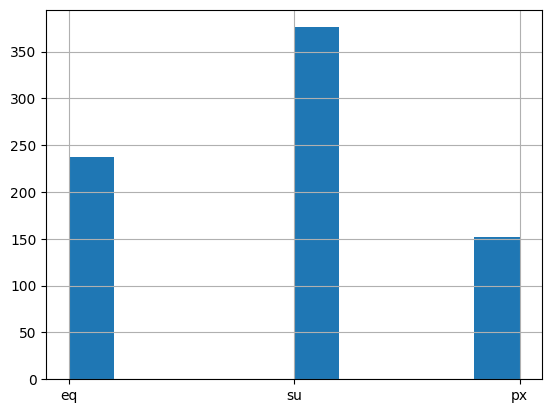

In [16]:
common_events['most_common_class'].hist()

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


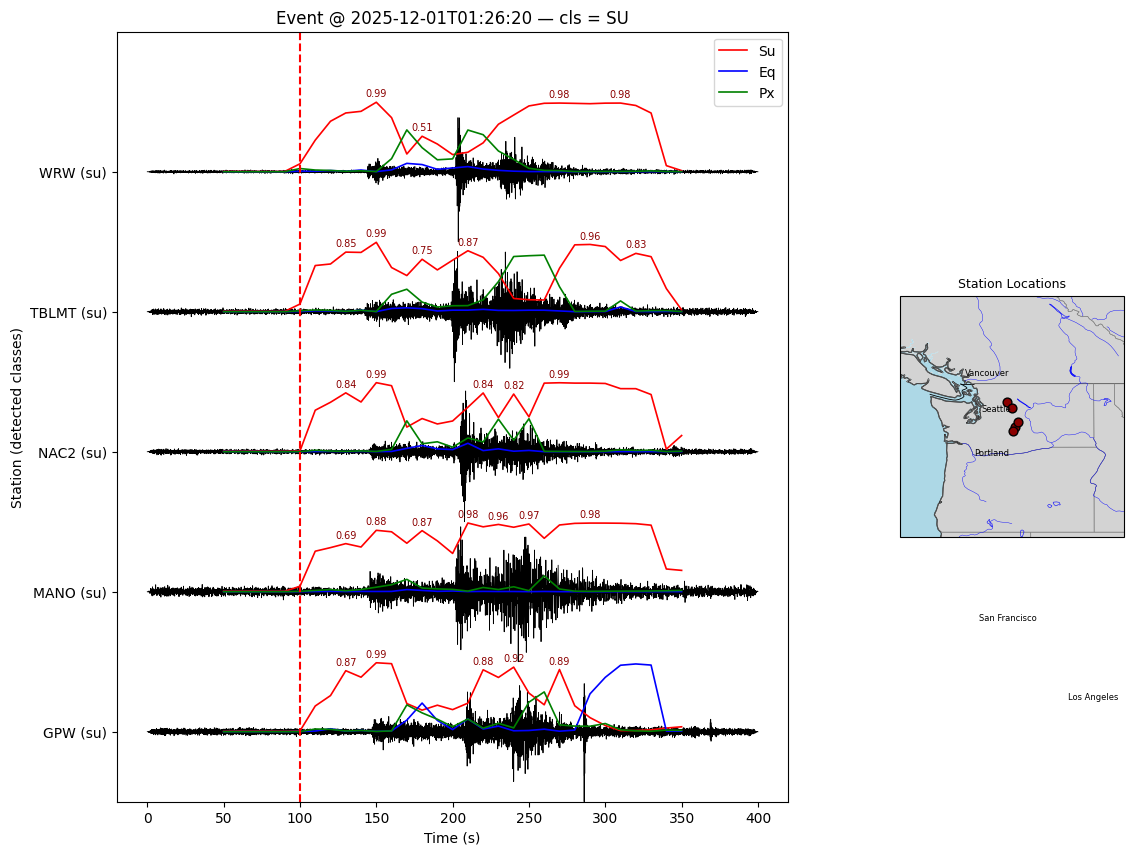

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


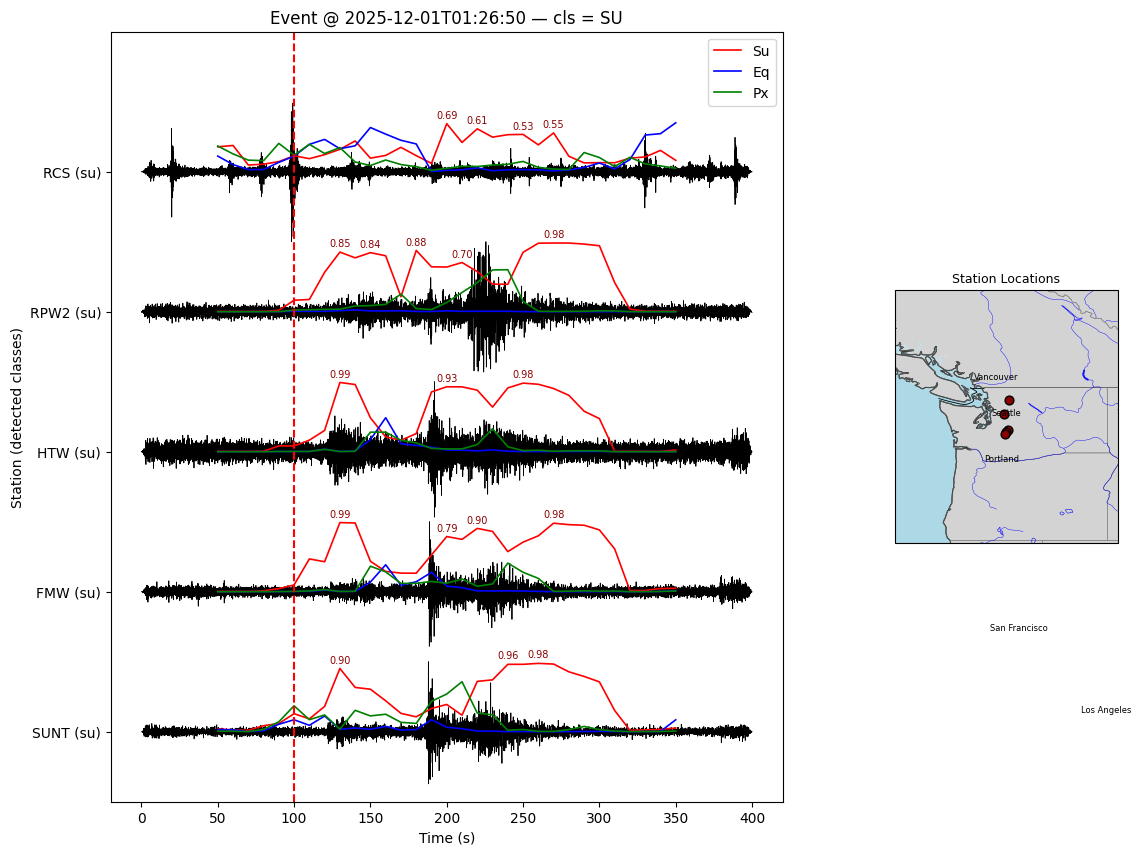

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


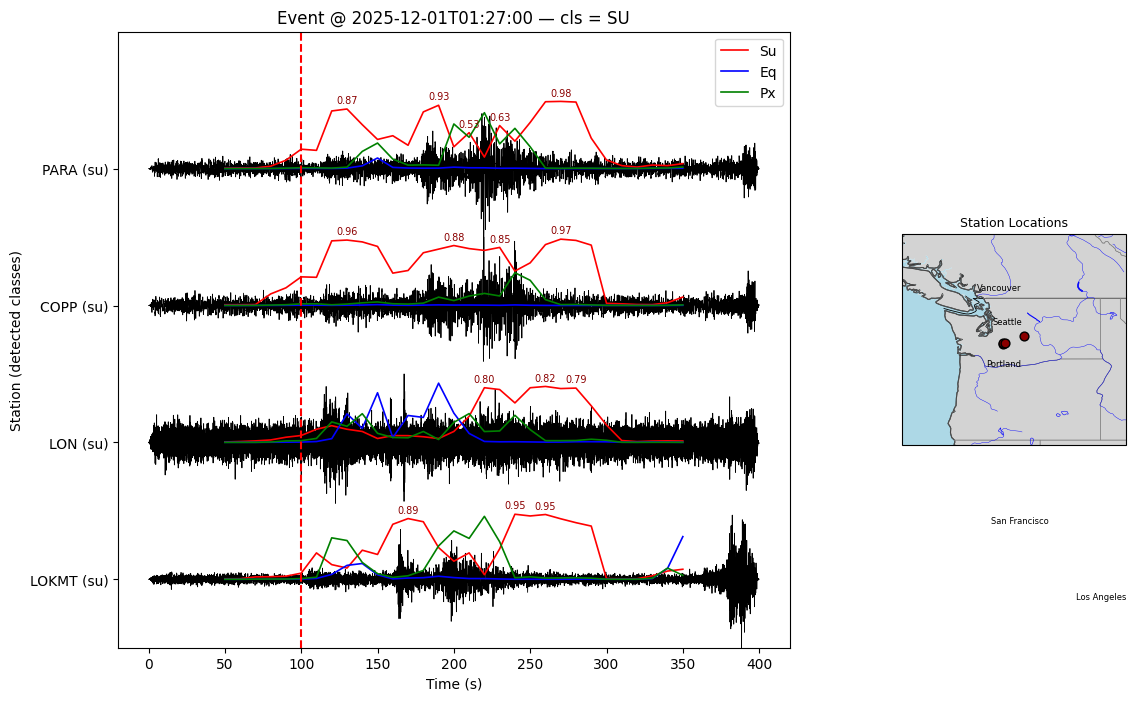

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


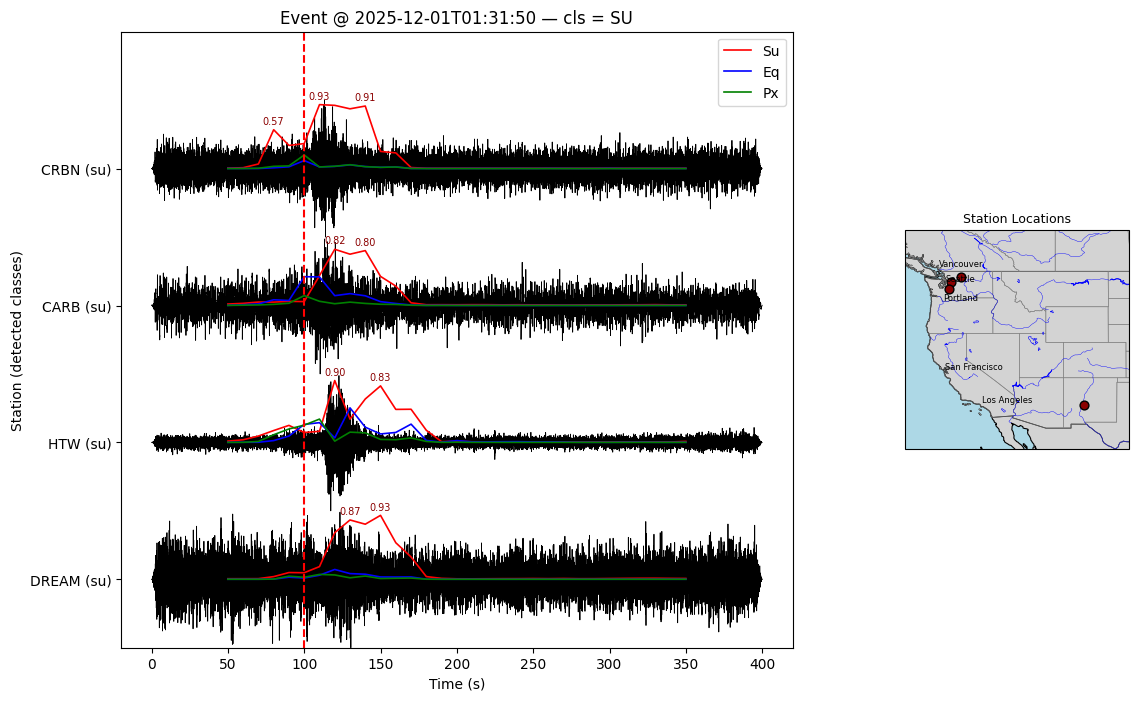

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


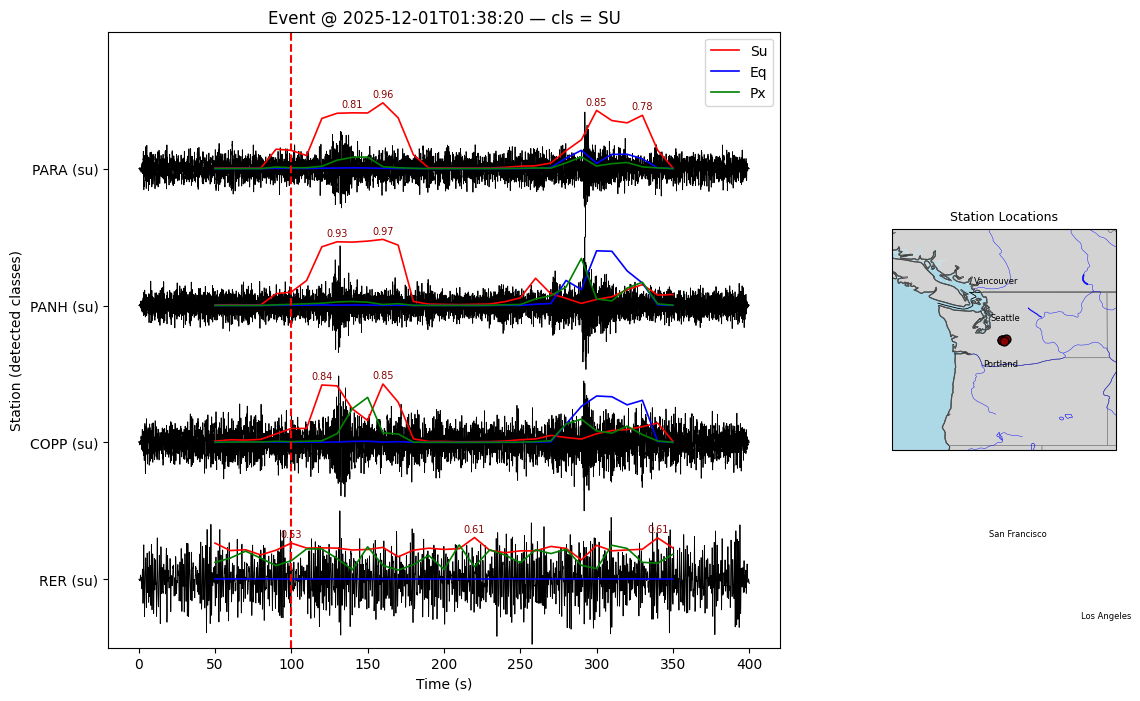

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


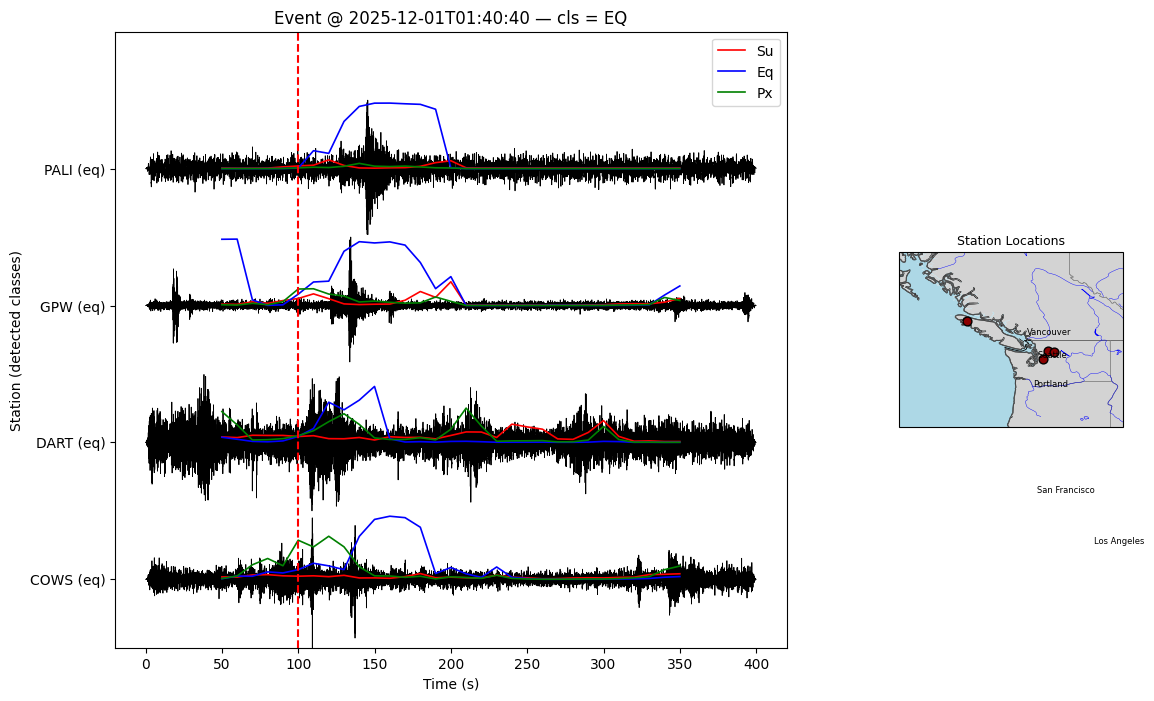

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


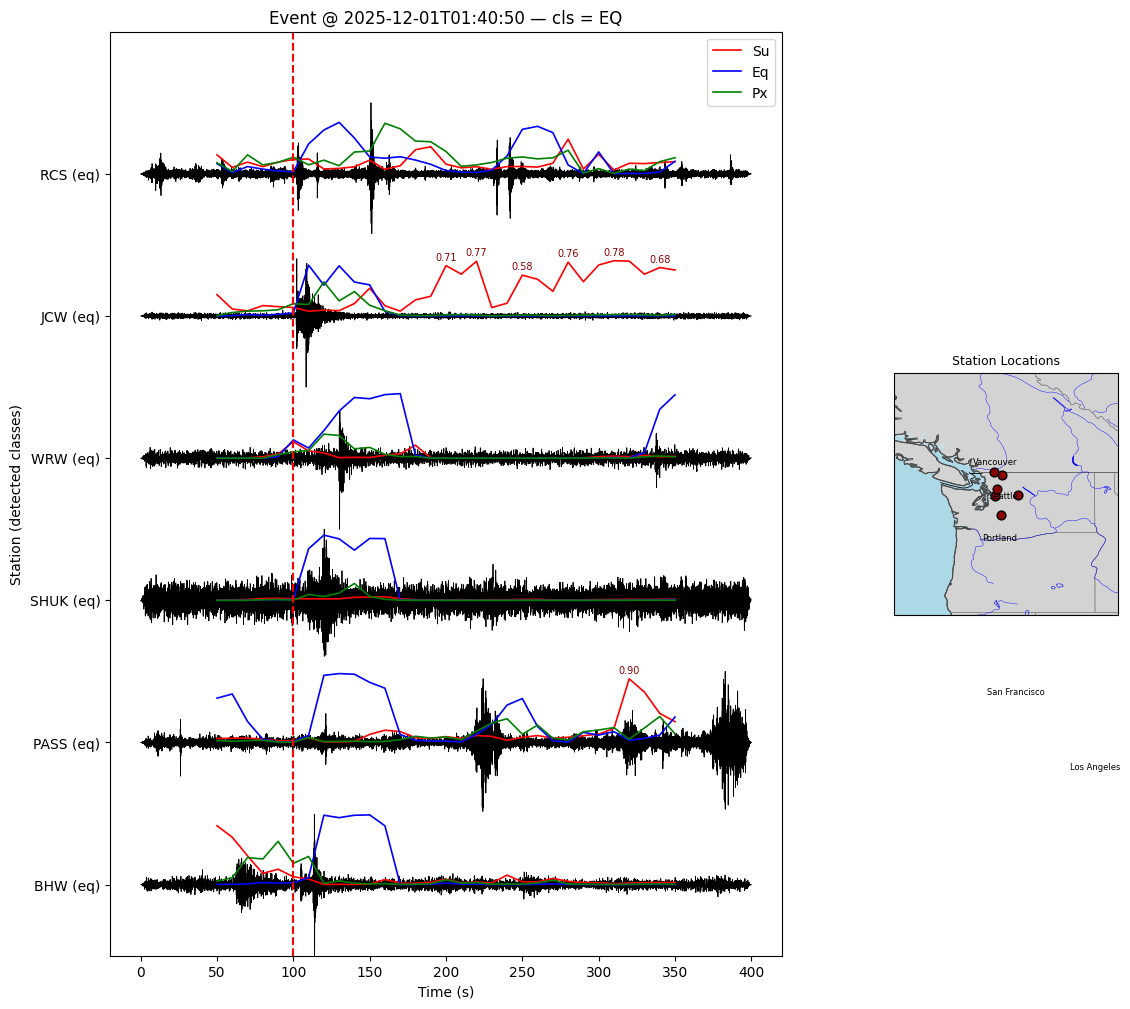

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


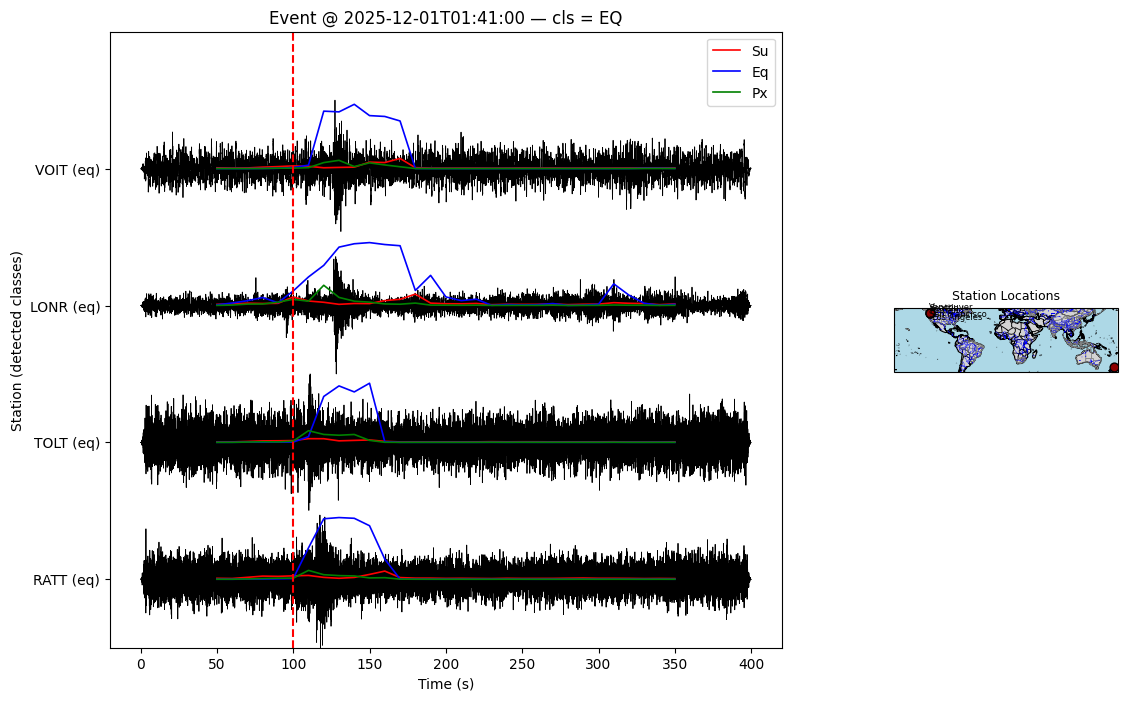

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


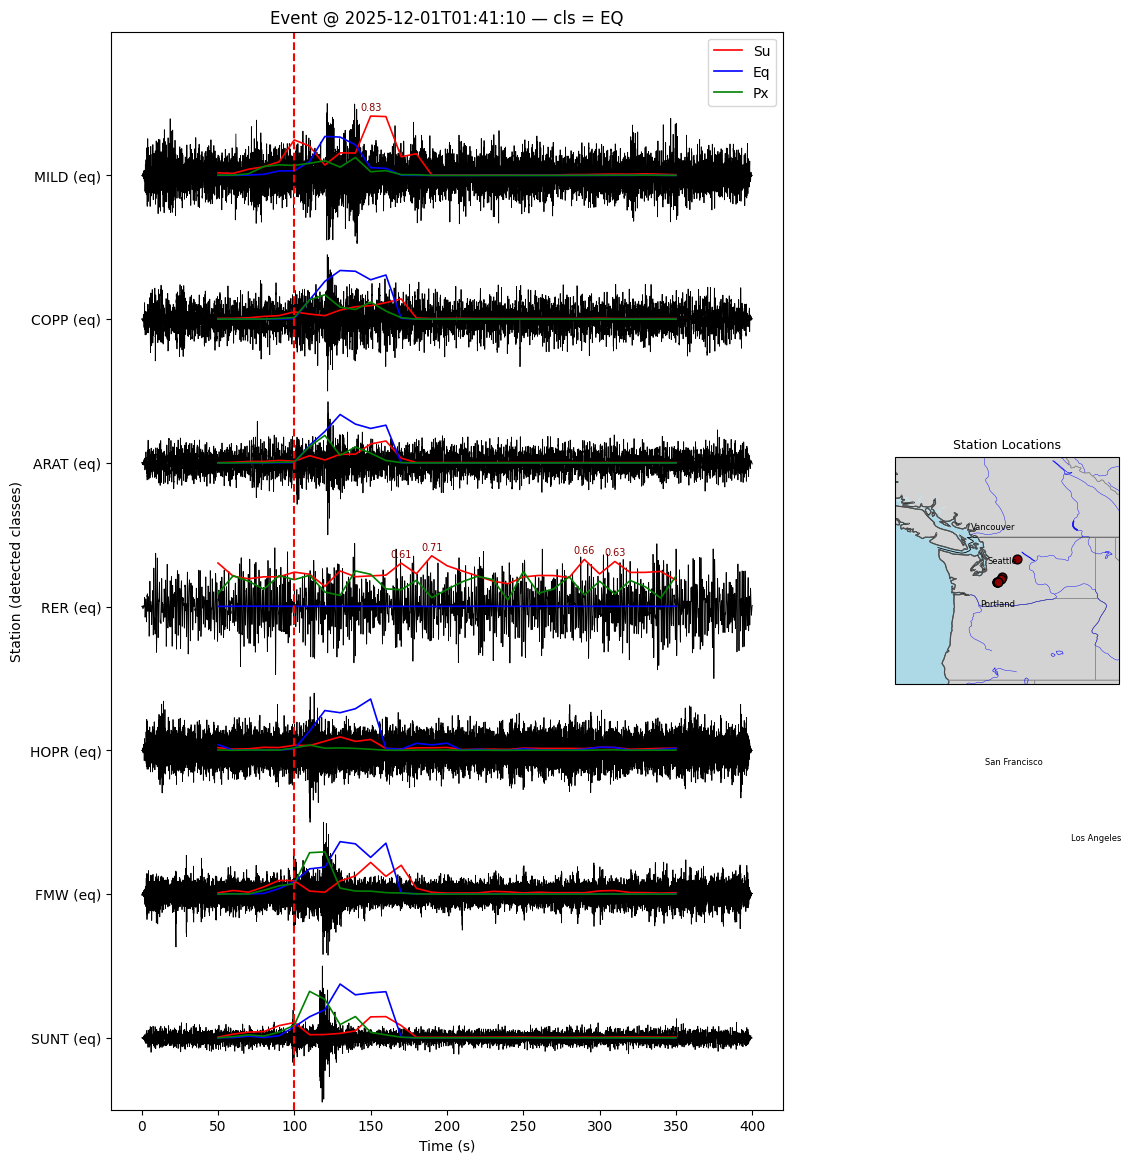

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


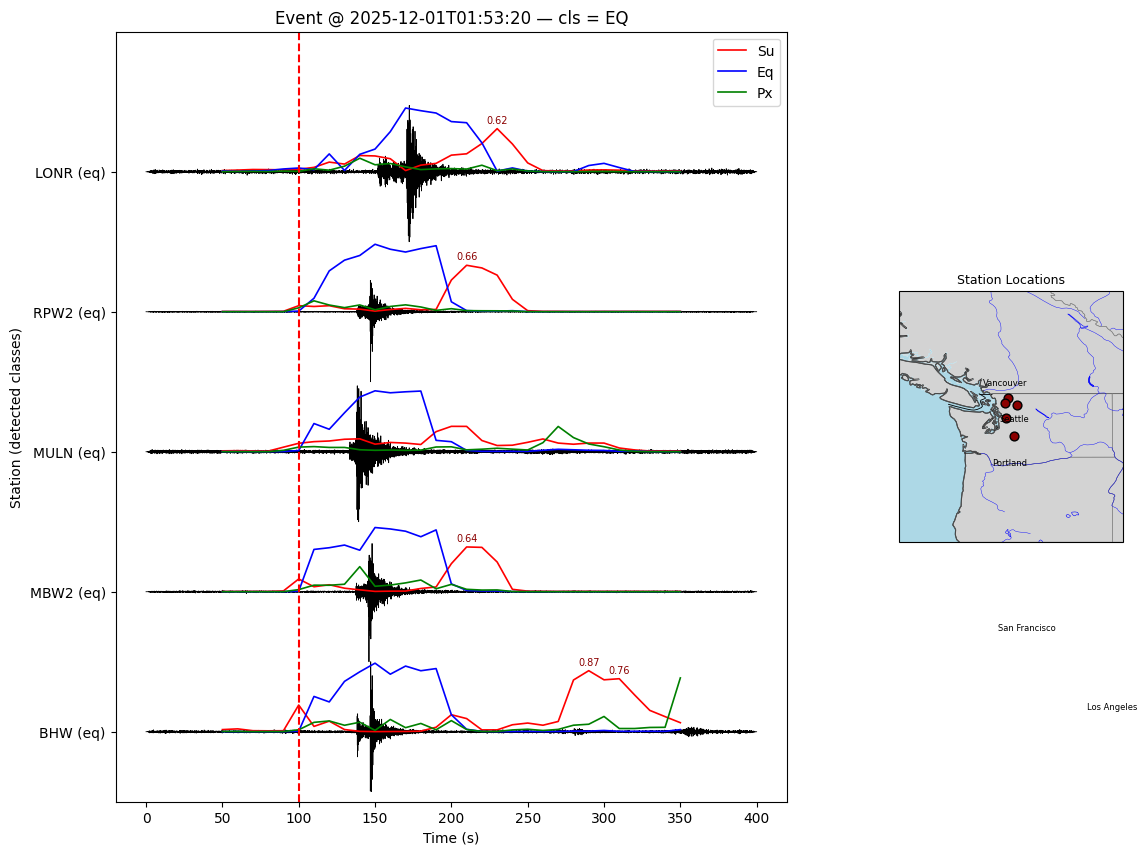

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


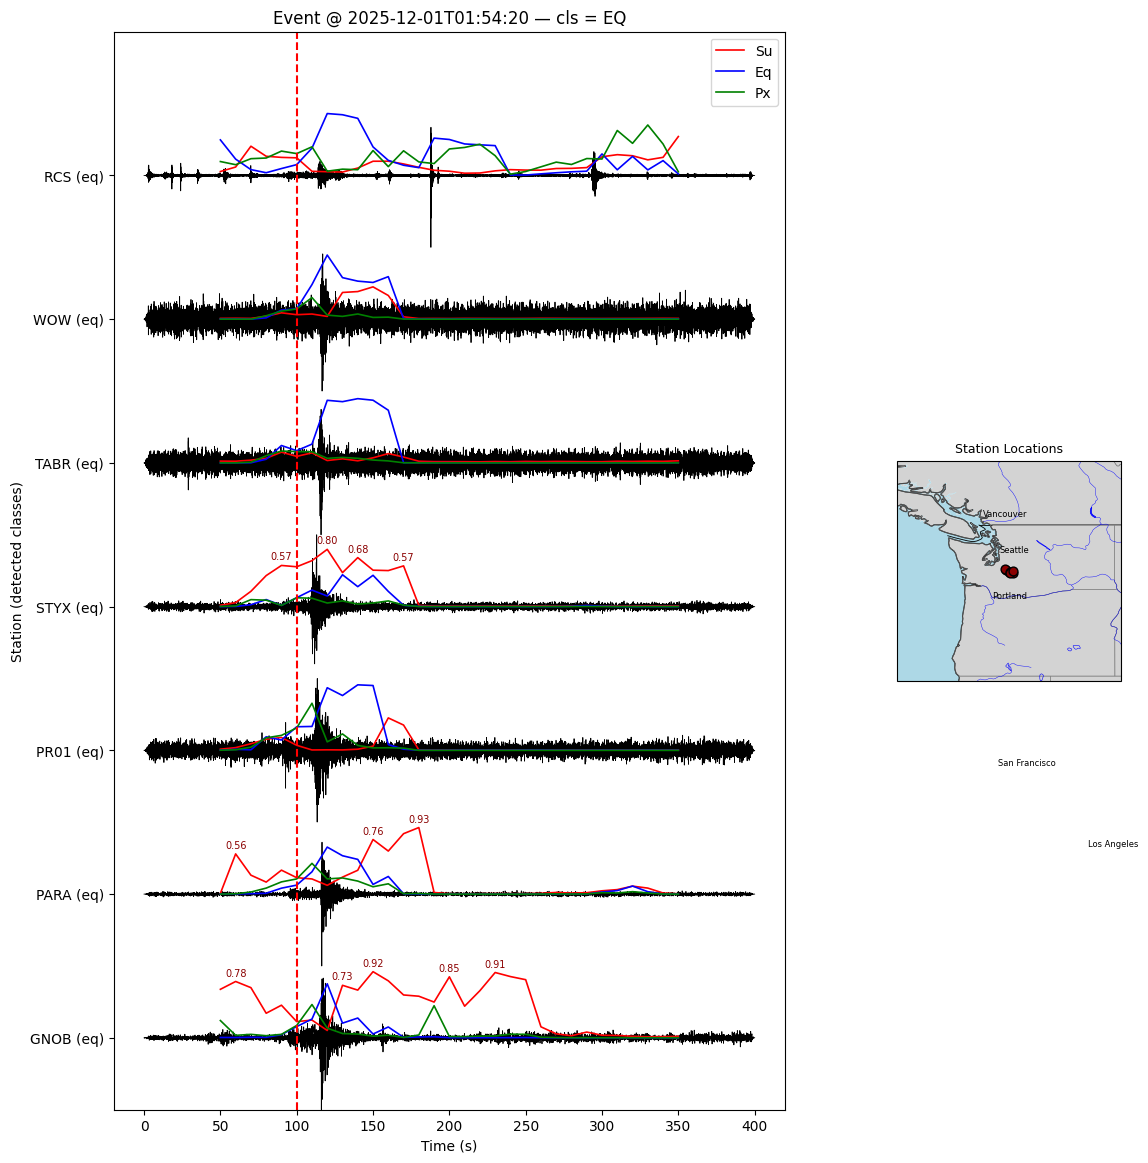

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


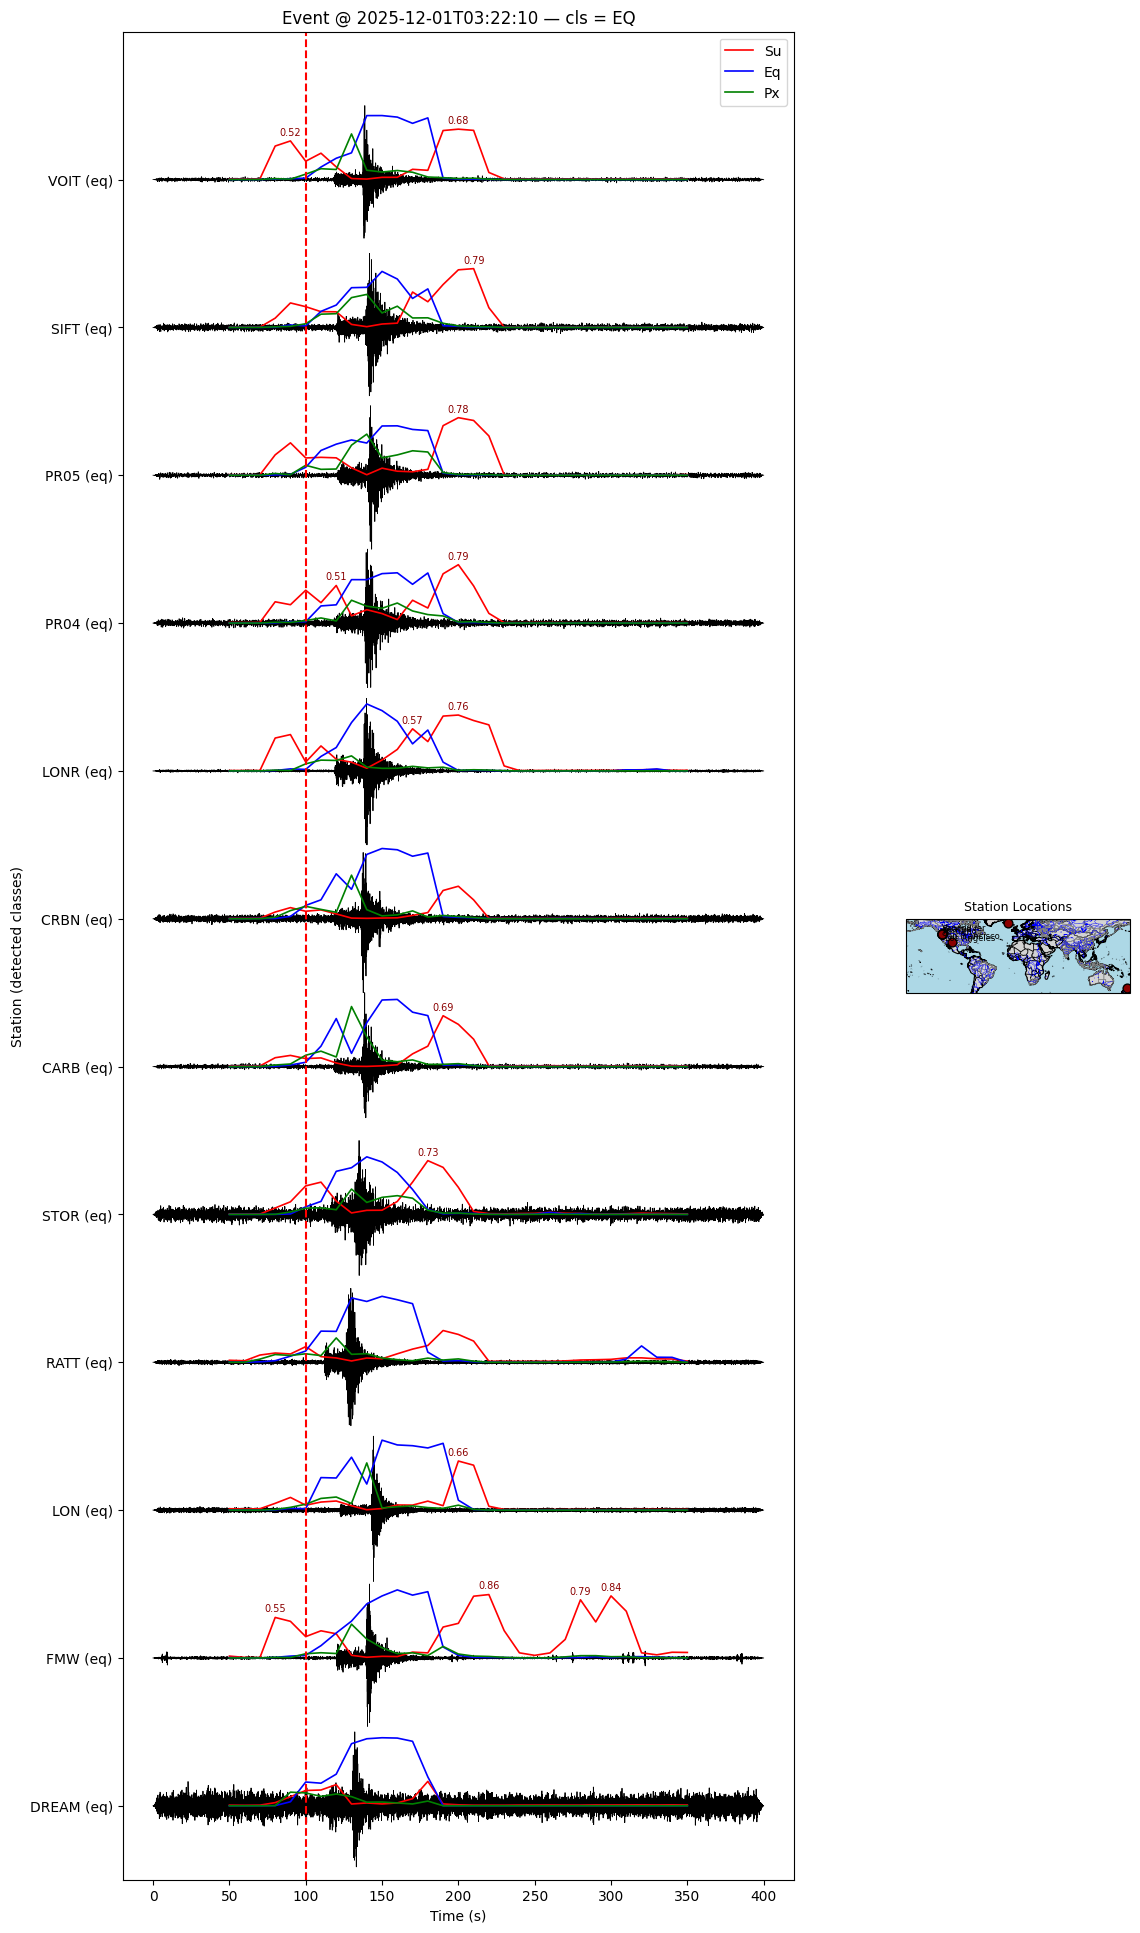

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


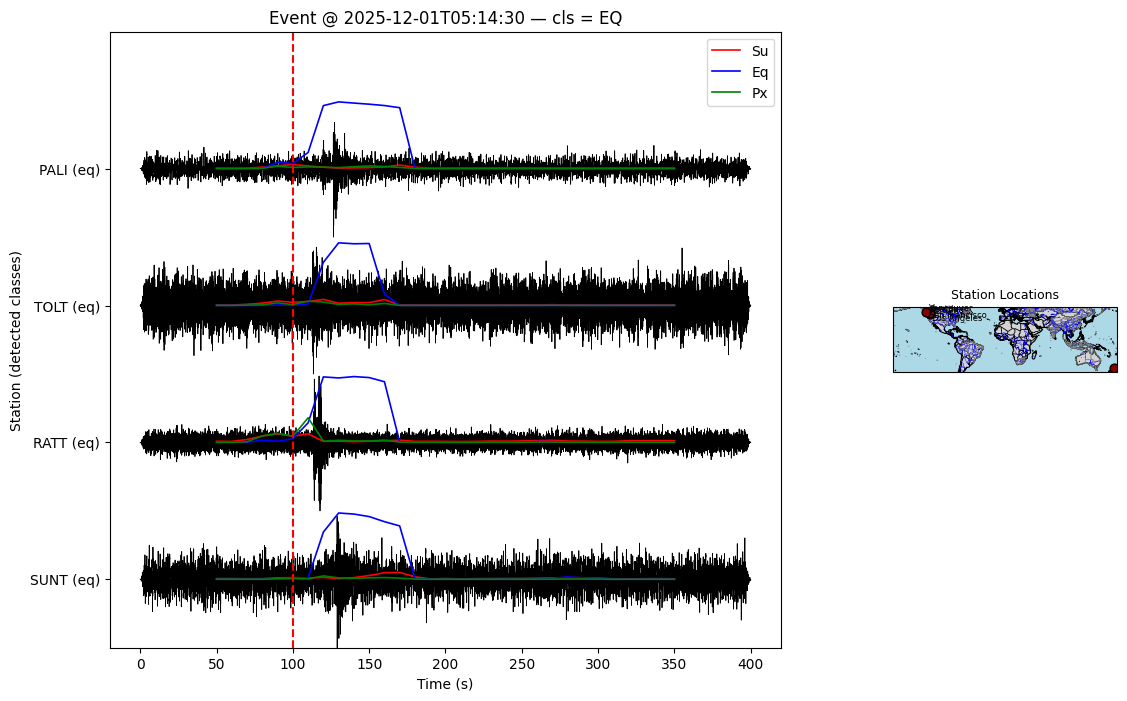

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


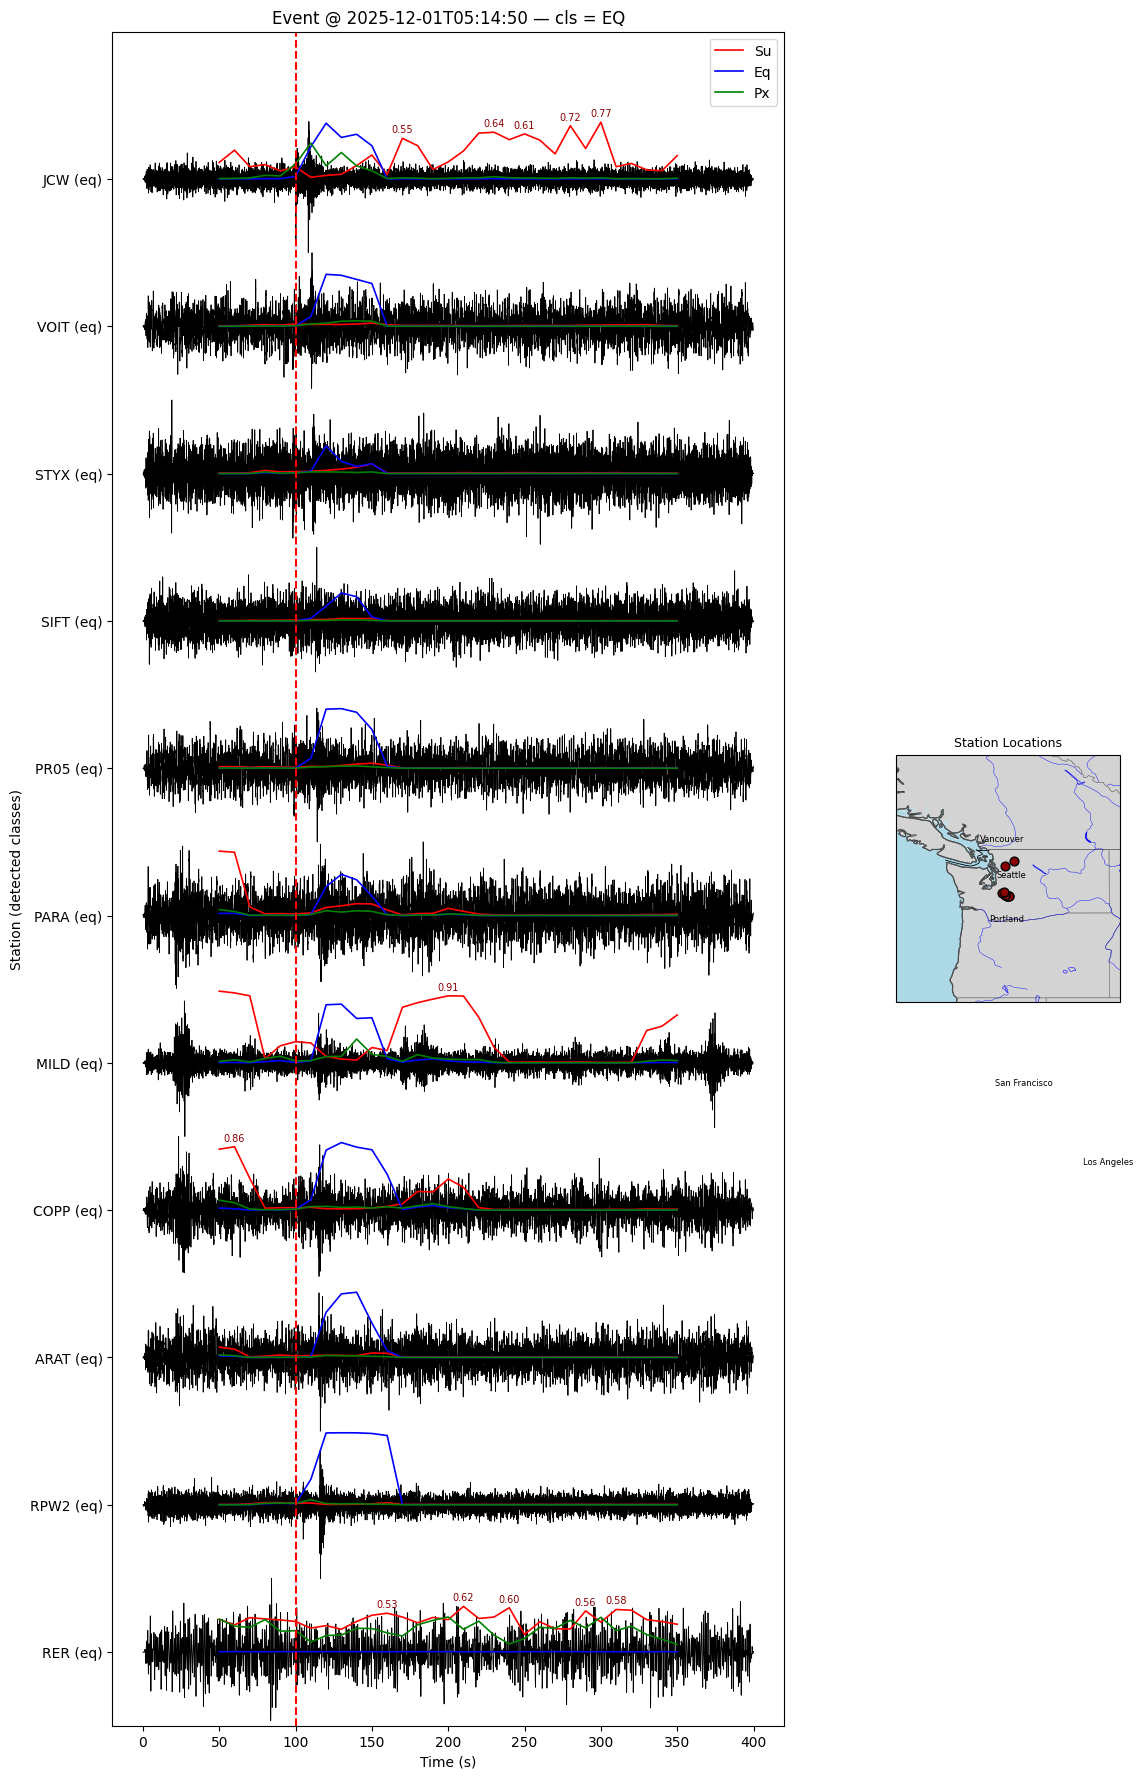

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


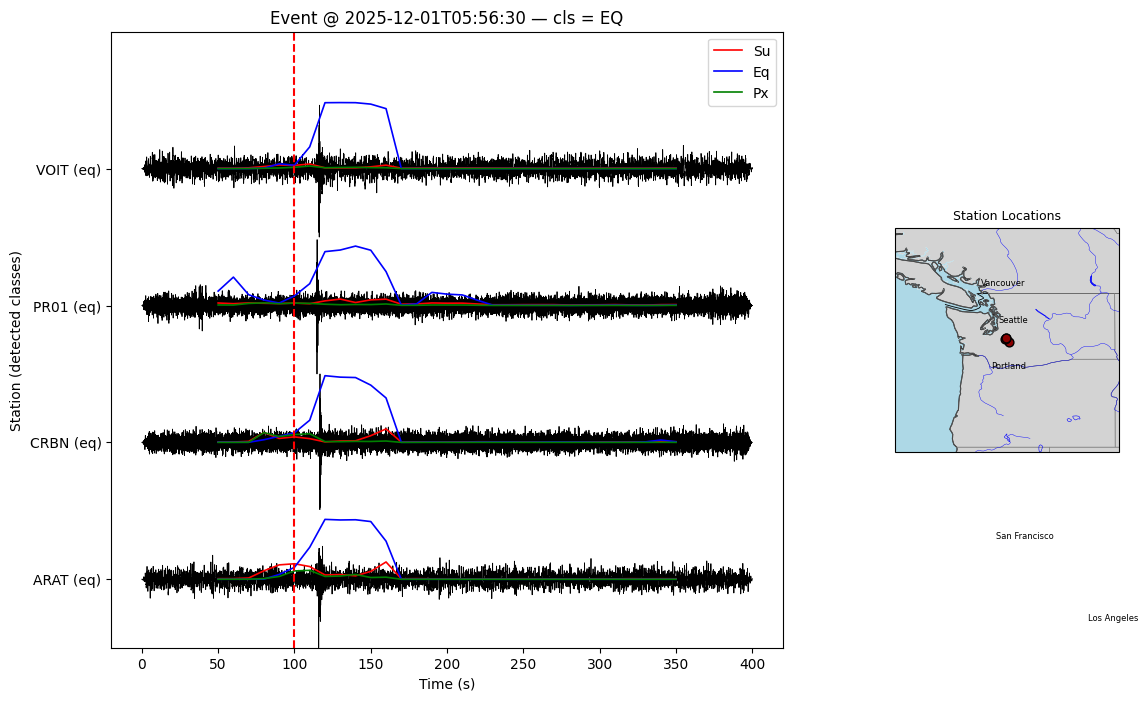

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


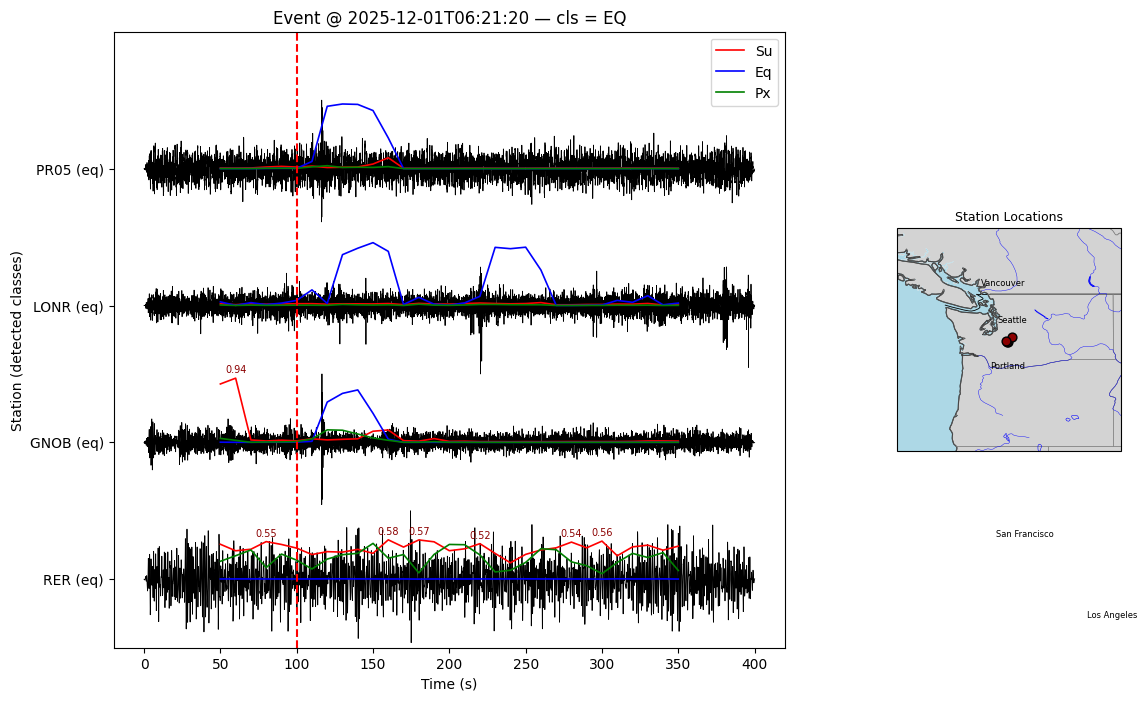

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


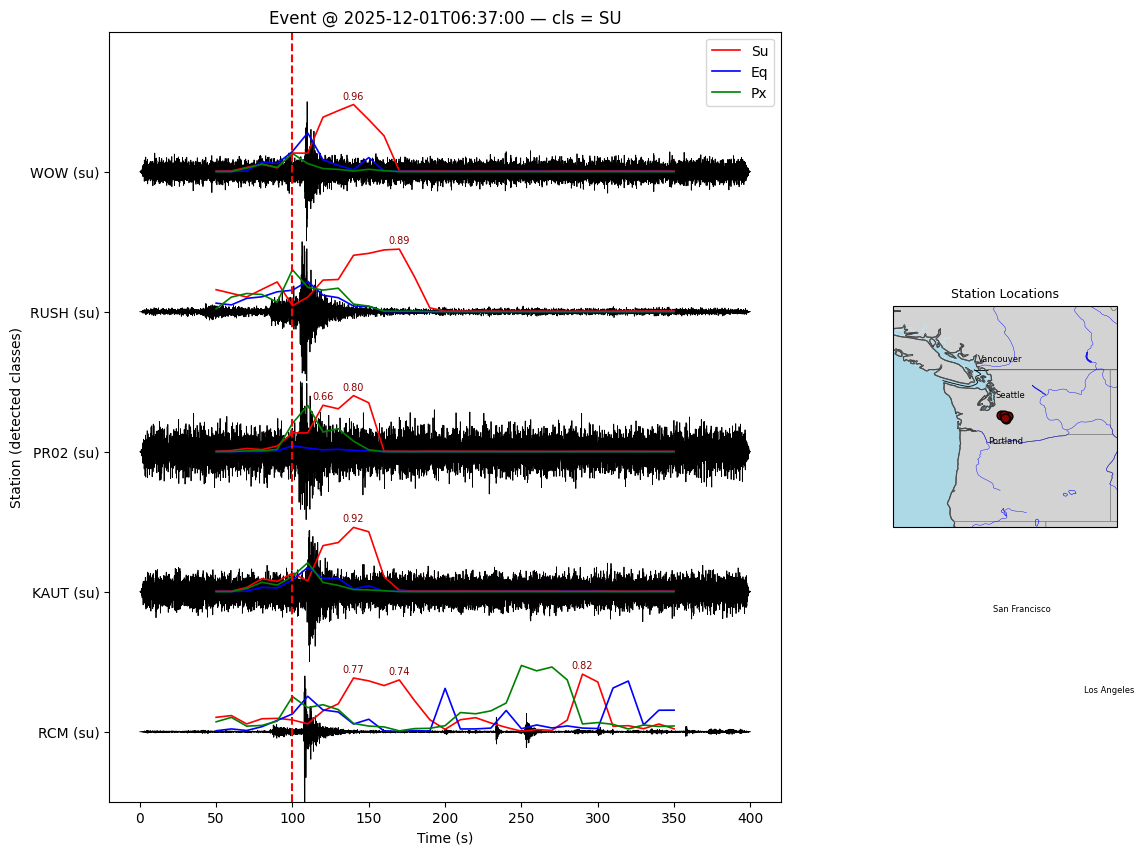

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


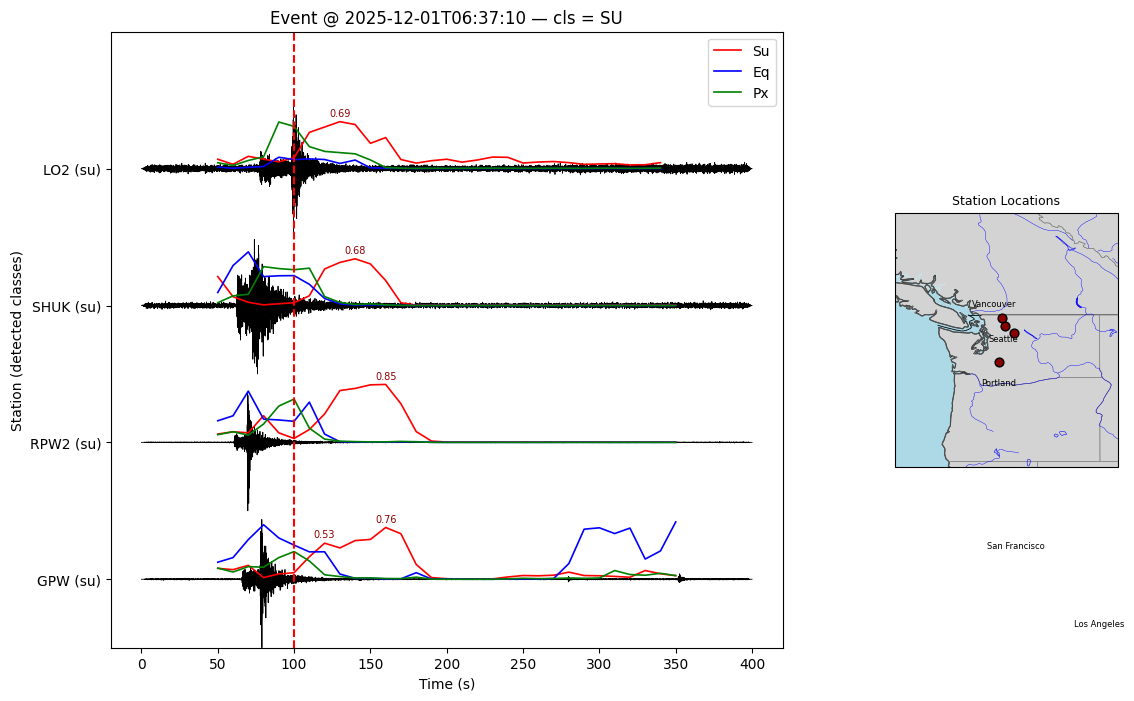

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


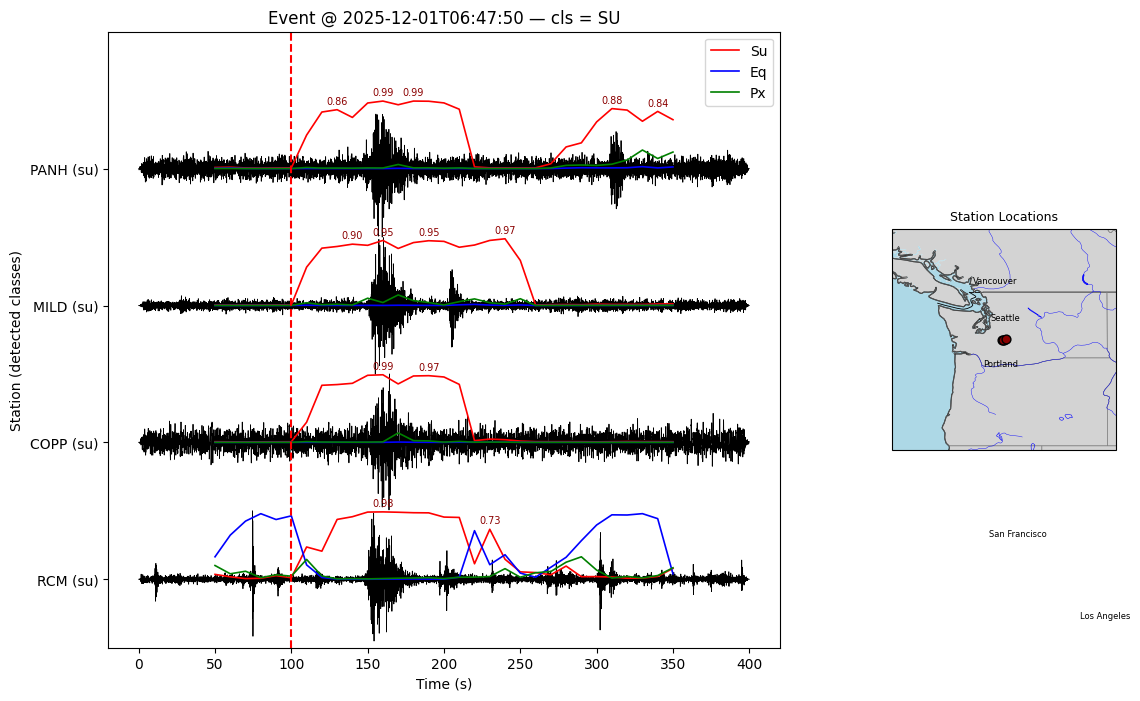

/tmp/ipykernel_2070608/3612480478.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


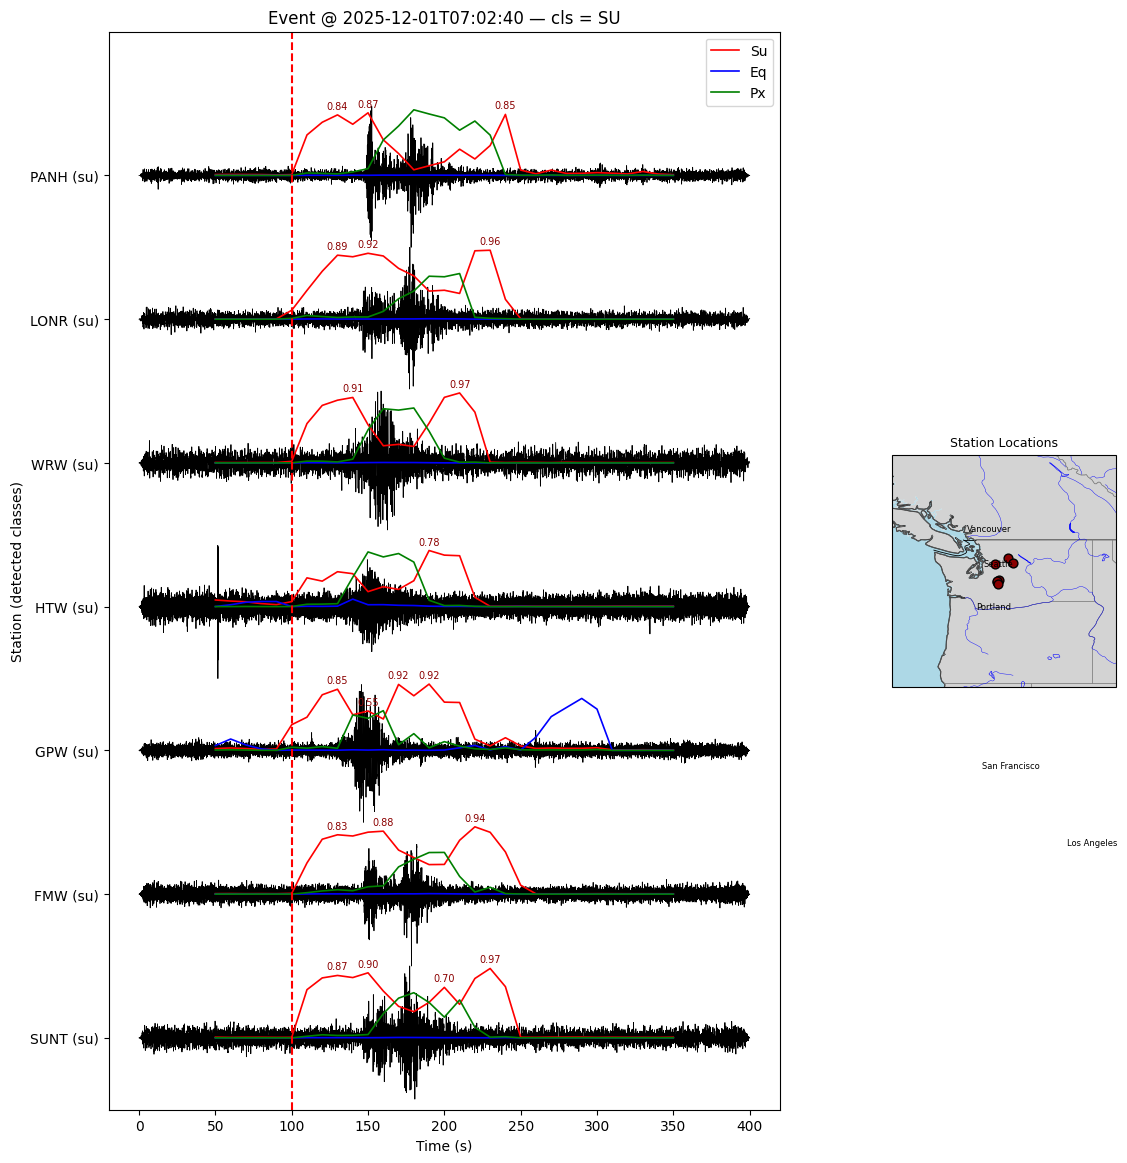

In [18]:
for i in range(20):#range(len(uniform_df)):
    plot_event_waveforms_general(uniform_df.iloc[i], duration= 300)


# Visualizing the picks

## Loading various pretrained picking models

In [95]:
# Various pre-trained weights for PhaseNet
# pn_model = sbm.PhaseNet.from_pretrained("ethz")
# pn_model = sbm.PhaseNet.from_pretrained("instance")
# pn_model = sbm.PhaseNet.from_pretrained("scedc")
pn_model = sbm.PhaseNet.from_pretrained("stead")
# pn_model = sbm.PhaseNet.from_pretrained("geofon")
# pn_model = sbm.PhaseNet.from_pretrained("neic")

# Various pre-trained weights for EQT
eqt_model = sbm.EQTransformer.from_pretrained("original")
#eqt_model = sbm.EQTransformer.from_pretrained("ethz")
# eqt_model = sbm.EQTransformer.from_pretrained("instance")
#eqt_model = sbm.EQTransformer.from_pretrained("scedc")
# eqt_model = sbm.EQTransformer.from_pretrained("stead")
# eqt_model = sbm.EQTransformer.from_pretrained("geofon")

# Various pre-trained weights for GPD
# gpd_model = sbm.GPD.from_pretrained("original")
# gpd_model = sbm.GPD.from_pretrained("ethz")
# gpd_model = sbm.GPD.from_pretrained("scedc")
gpd_model = sbm.GPD.from_pretrained("stead")
# gpd_model = sbm.GPD.from_pretrained("geofon")
# gpd_model = sbm.GPD.from_pretrained("neic")

In [101]:
def plot_event_waveforms_and_picks(event_row, duration=300, peak_thresh=0.50, model = gpd_model):
    client      = Client("IRIS")
    event_time  = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())
    stations    = ast.literal_eval(event_row["stations"])
    target_cls  = event_row["most_common_class"]

    fig, ax = plt.subplots(figsize=(10, 2 * len(stations)))

    y_offsets = []
    for i, sta in enumerate(stations):
        try:
            st = client.get_waveforms("*", sta, "*", "*HZ",
                                      starttime=event_time,
                                      endtime=event_time + duration)
            st.resample(50)
            

            # ── inference ───────────────────────────────────────────────
            probs_st = model.annotate(st)
            

        
            probs_tr_0 = probs_st[0]
            probs_tr_1 = probs_st[1]
            probs_tr_2 = probs_st[2]
            
            t_probs  = probs_tr_0.times() 
            
            
            d_probs_0  = probs_tr_0.data*2
            d_probs_1 = probs_tr_1.data*2
            d_probs_2 = probs_tr_2.data*2

            # ── waveform prep ───────────────────────────────────────────
            st.detrend("linear"); st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)
            tr       = st[0]
            t_wave   = tr.times("relative")
            y_wave   = tr.data / np.abs(tr.data).max()

            # ── plot ────────────────────────────────────────────────────
            offset = 2 * i
            y_offsets.append(offset)
            ax.plot(t_wave,  y_wave + offset,  lw=0.6, color="black")
            
            
            t_max = t_wave[np.argmax(y_wave+offset)]
         
            ax.plot(t_probs, d_probs_0 + offset, lw=1.2, color = 'orange')
            ax.plot(t_probs, d_probs_1 + offset, lw=1.2, color = 'blue')
            ax.plot(t_probs, d_probs_2 + offset, lw=1.2, color = 'green')

            # annotate peaks above threshold
            """
            peaks = np.where((d_probs[1:-1] > d_probs[:-2]) &
                             (d_probs[1:-1] > d_probs[2:]) &
                             (d_probs[1:-1] >= peak_thresh))[0] + 1
            for p in peaks:
                ax.text(t_probs[p], d_probs[p] + offset + 0.05,
                        f"{d_probs[p]:.2f}", ha="center", va="bottom",
                        fontsize=7, color="darkblue")
            """
        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ── styling ────────────────────────────────────────────────────────
    ax.axvline(0, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")

    # put station names on y-axis at the row centers
    #ax.set_yticks(y_offsets)
    #ax.set_yticklabels(stations)
    ax.set_ylabel("Station")

    #ax.set_xlim( t_max - 50, t_max + 50)
    #ax.set_ylim(-1, 2 * len(stations))
    plt.tight_layout()
    plt.show()


In [122]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client


def plot_event_waveforms_and_picks(
    event_row,
    duration=300,
    peak_thresh=0.50,
    model=None
):
    client     = Client("IRIS")
    event_time = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())
    stations   = ast.literal_eval(event_row["stations"])
    target_cls = event_row["most_common_class"]

    fig, axes = plt.subplots(
        nrows=2 * len(stations),
        ncols=1,
        figsize=(12, 3 * len(stations)),
        sharex=True
    )

    if len(stations) == 1:
        axes = [axes]

    for i, sta in enumerate(stations):
        ax_wave = axes[2 * i]
        ax_spec = axes[2 * i + 1]

        try:
            # ── waveform download ──────────────────────────────────────
            st = client.get_waveforms(
                "*", sta, "*", "*HZ",
                starttime=event_time,
                endtime=event_time + duration
            )
            st.resample(50)

            # ── inference ──────────────────────────────────────────────
            probs_st = model.annotate(st)

            probs_tr_0 = probs_st[0]
            probs_tr_1 = probs_st[1]
            probs_tr_2 = probs_st[2]

            t_probs = probs_tr_0.times()
            d_probs_0 = probs_tr_0.data * 2
            d_probs_1 = probs_tr_1.data * 2
            d_probs_2 = probs_tr_2.data * 2

            # ── waveform preprocessing ─────────────────────────────────
            st.detrend("linear")
            st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)

            tr = st[0]
            t_wave = tr.times("relative")
            y_wave = tr.data / np.abs(tr.data).max()

            # ── waveform + probabilities ───────────────────────────────
            ax_wave.plot(t_wave, y_wave, color="black", lw=0.7)
            ax_wave.plot(t_probs, d_probs_0, color="orange", lw=1.2)
            ax_wave.plot(t_probs, d_probs_1, color="blue", lw=1.2)
            ax_wave.plot(t_probs, d_probs_2, color="green", lw=1.2)

            ax_wave.axvline(0, color="red", ls="--", lw=0.8)
            ax_wave.set_ylabel(sta)

            # ── spectrogram ────────────────────────────────────────────
            ax_spec.specgram(
                tr.data,
                Fs=tr.stats.sampling_rate,
                NFFT= 32,
                noverlap= 20,
                cmap="magma",
                vmin = -10,
                vmax = 20
            )
            ax_spec.set_ylabel("Hz")
            ax_wave.set_xlim(50, 80)
            ax_spec.set_xlim(50,80)

        except Exception as e:
            print(f"❌ {sta}: {e}")
            ax_wave.set_ylabel(sta)

    axes[-1].set_xlabel("Time (s)")
    
    fig.suptitle(
        f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}",
        y=0.995
    )

    plt.tight_layout()
    plt.show()


/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


❌ LONR: No data available for request.
HTTP Status code: 204
Detailed response of server:




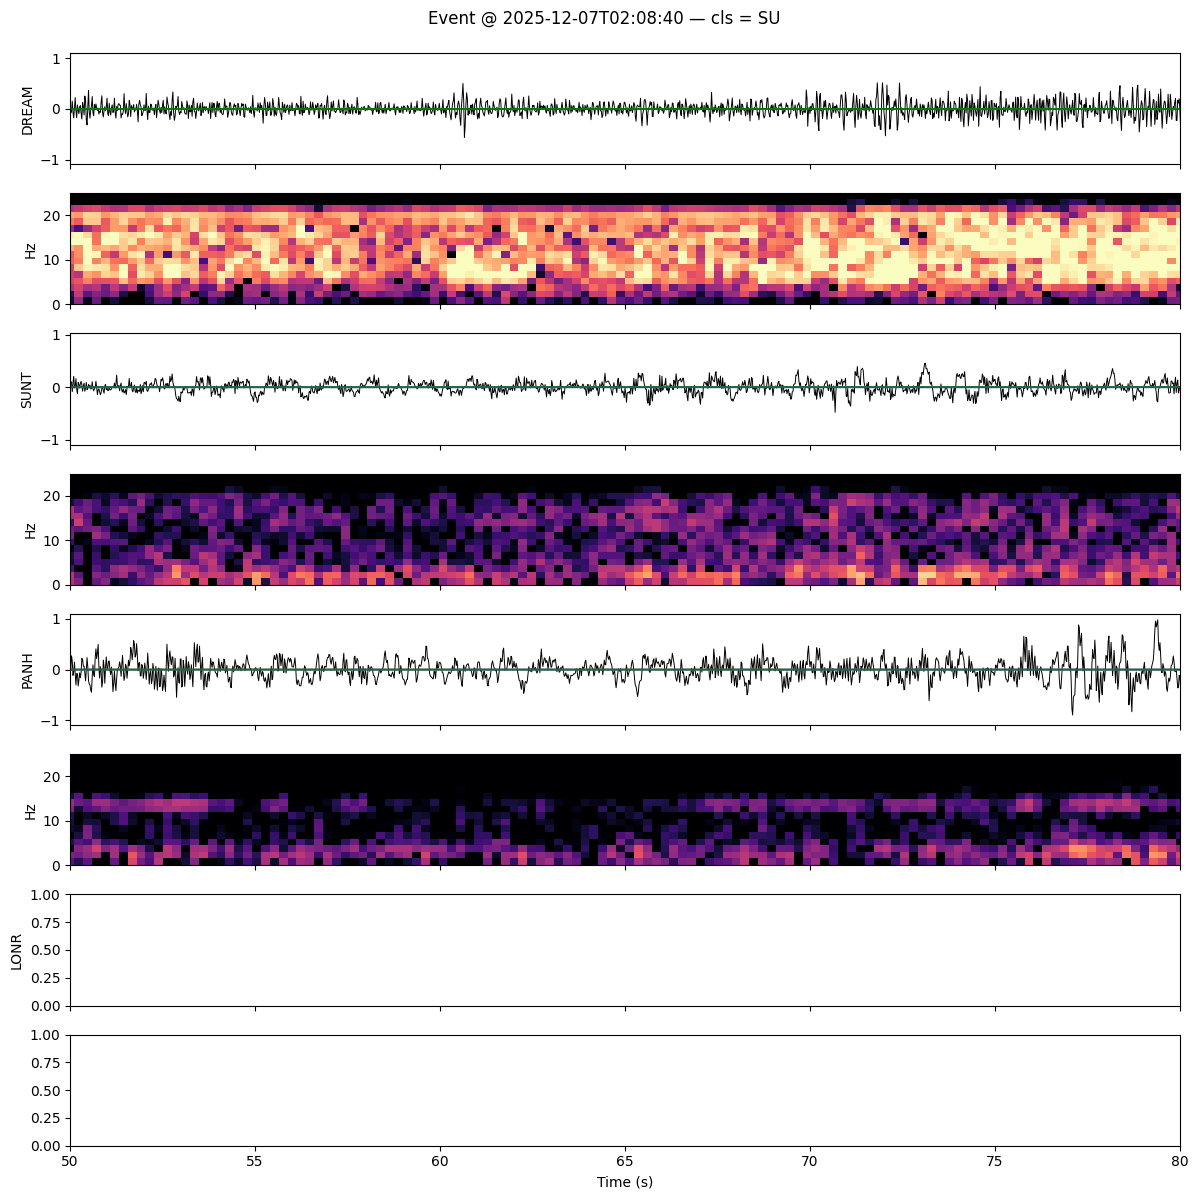

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/

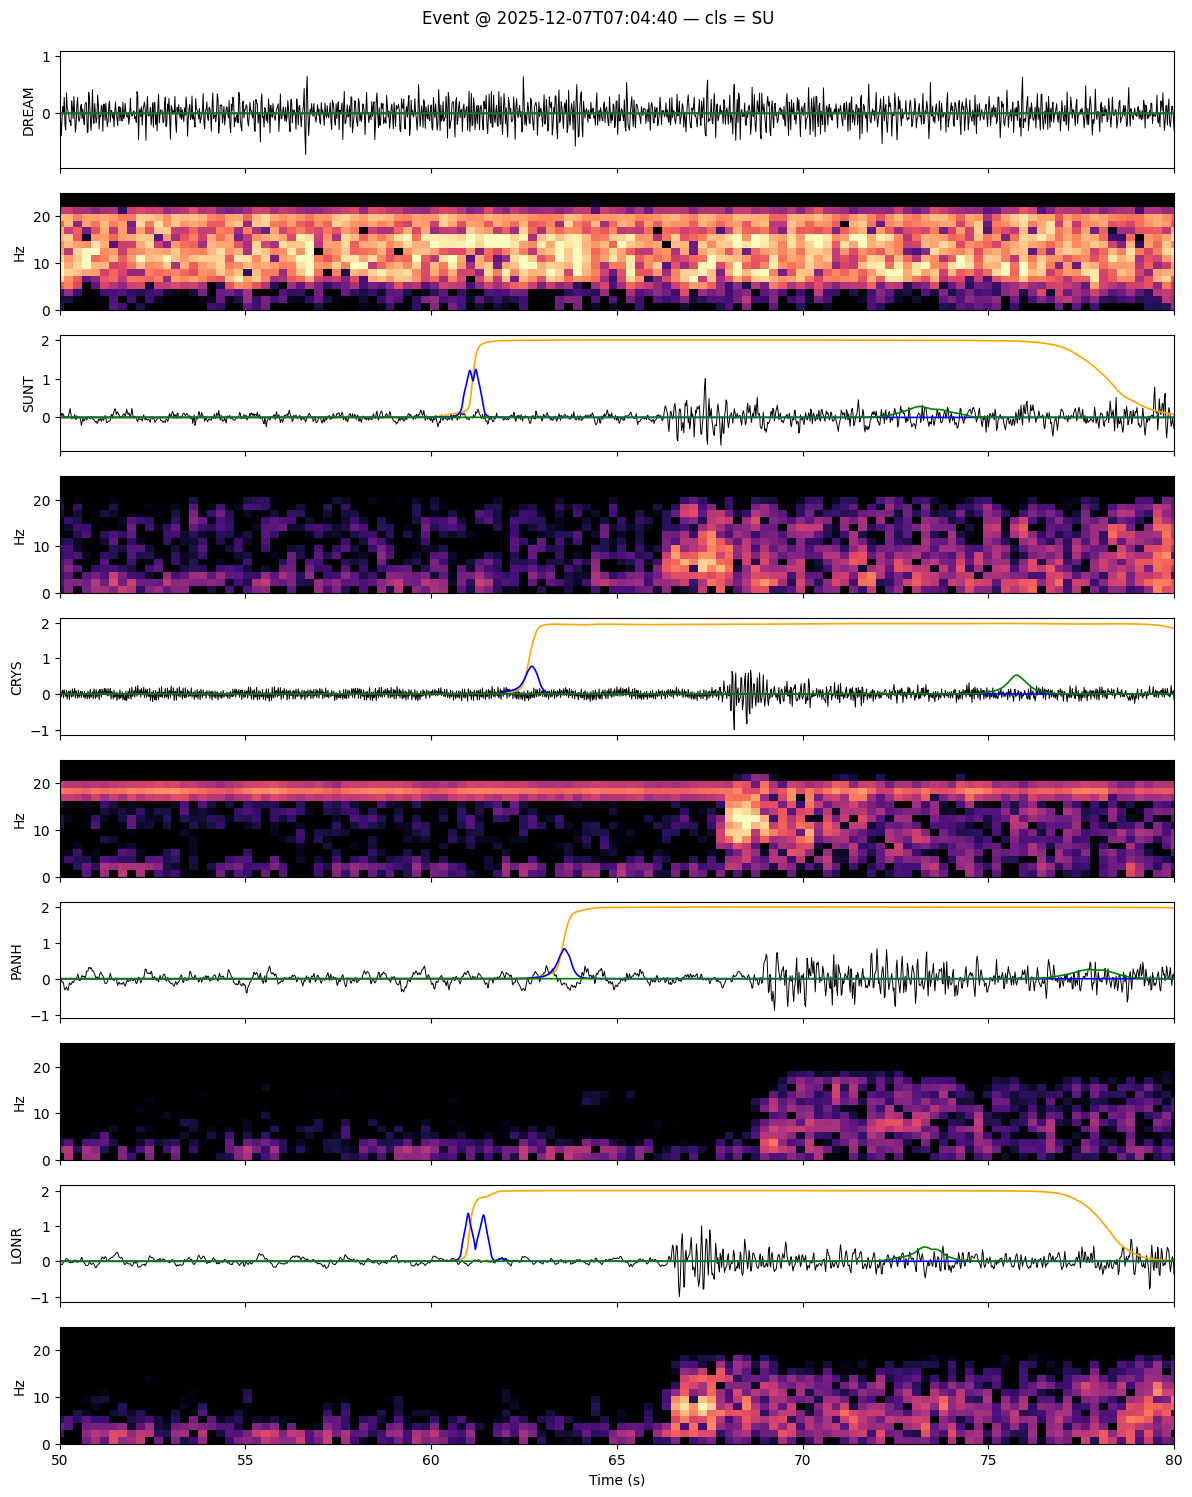

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/

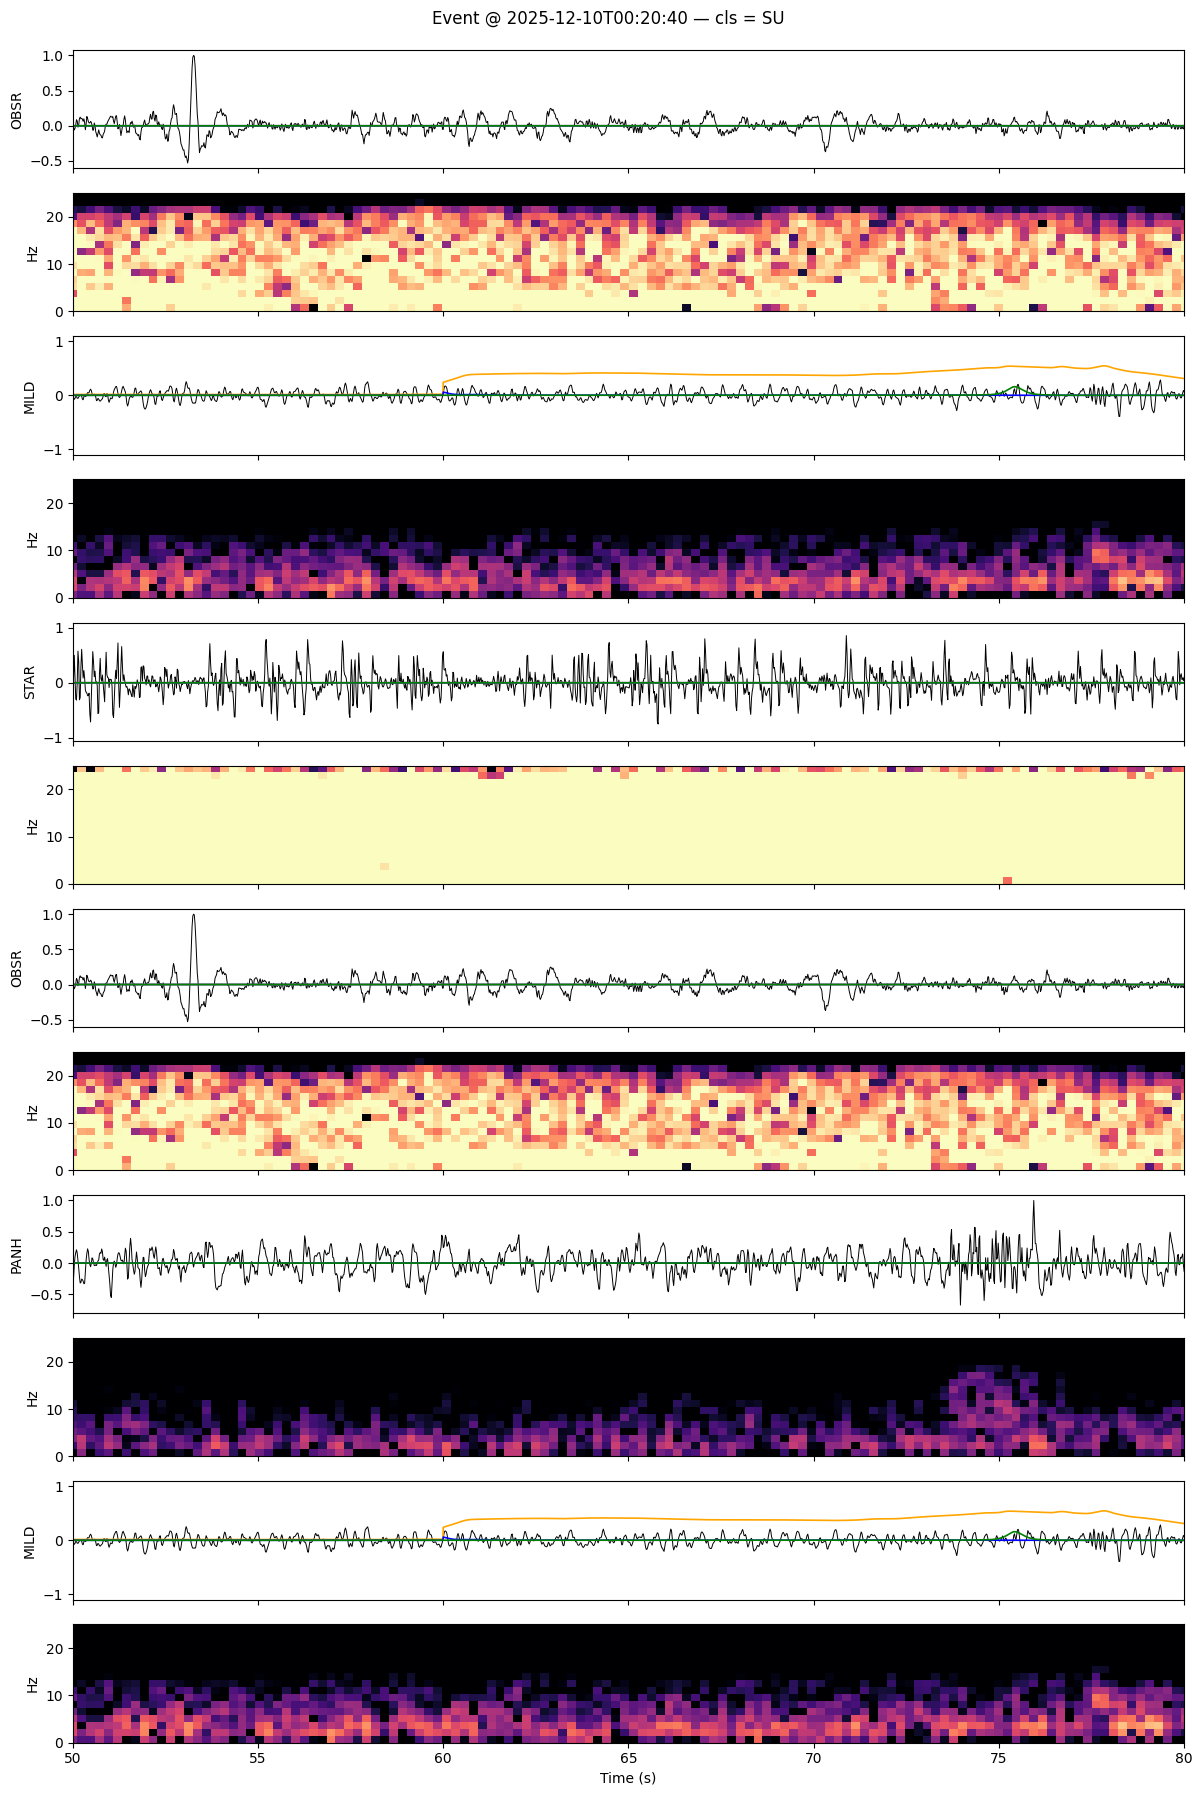

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/

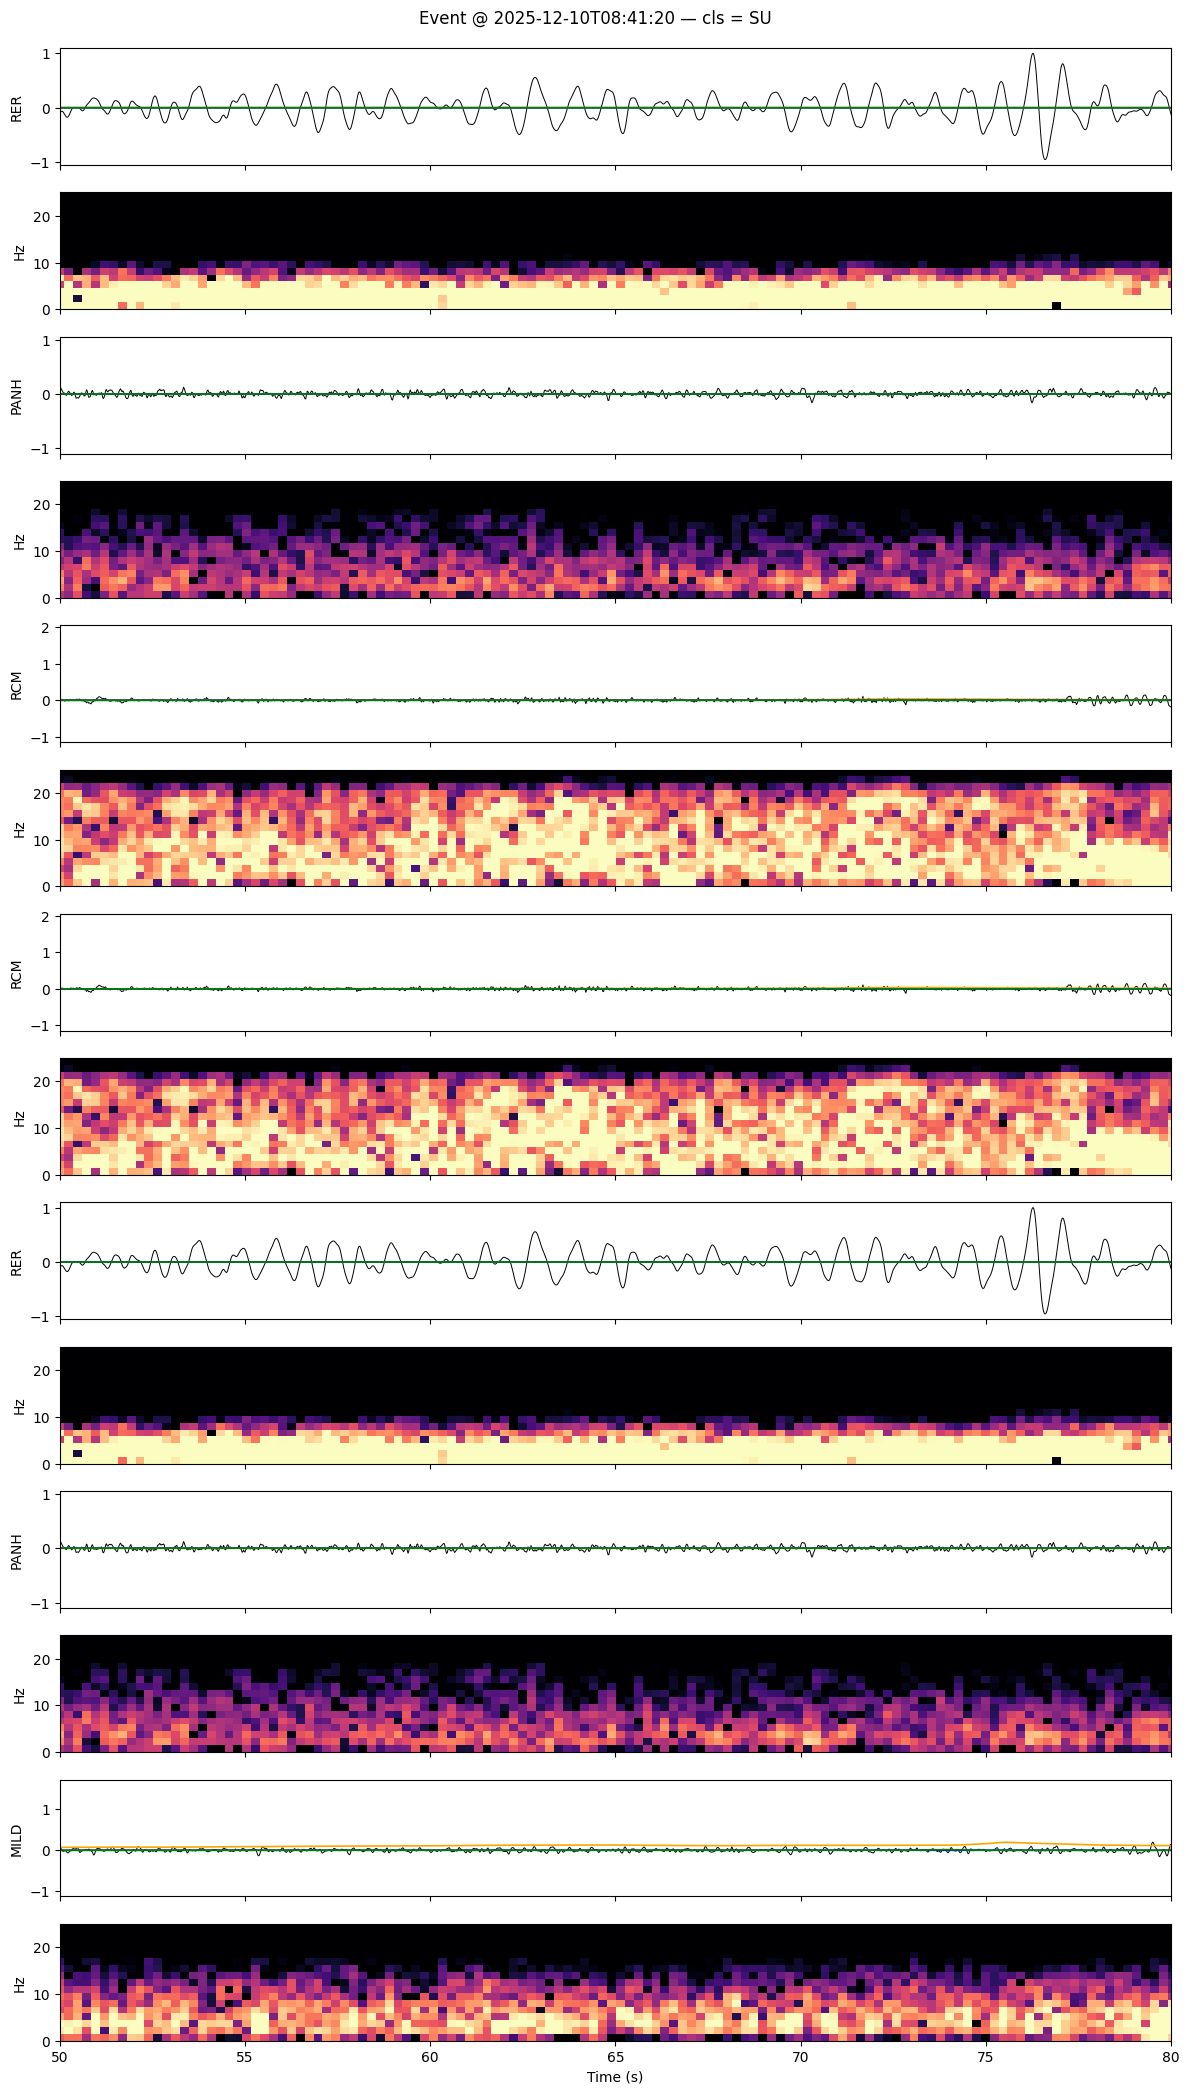

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


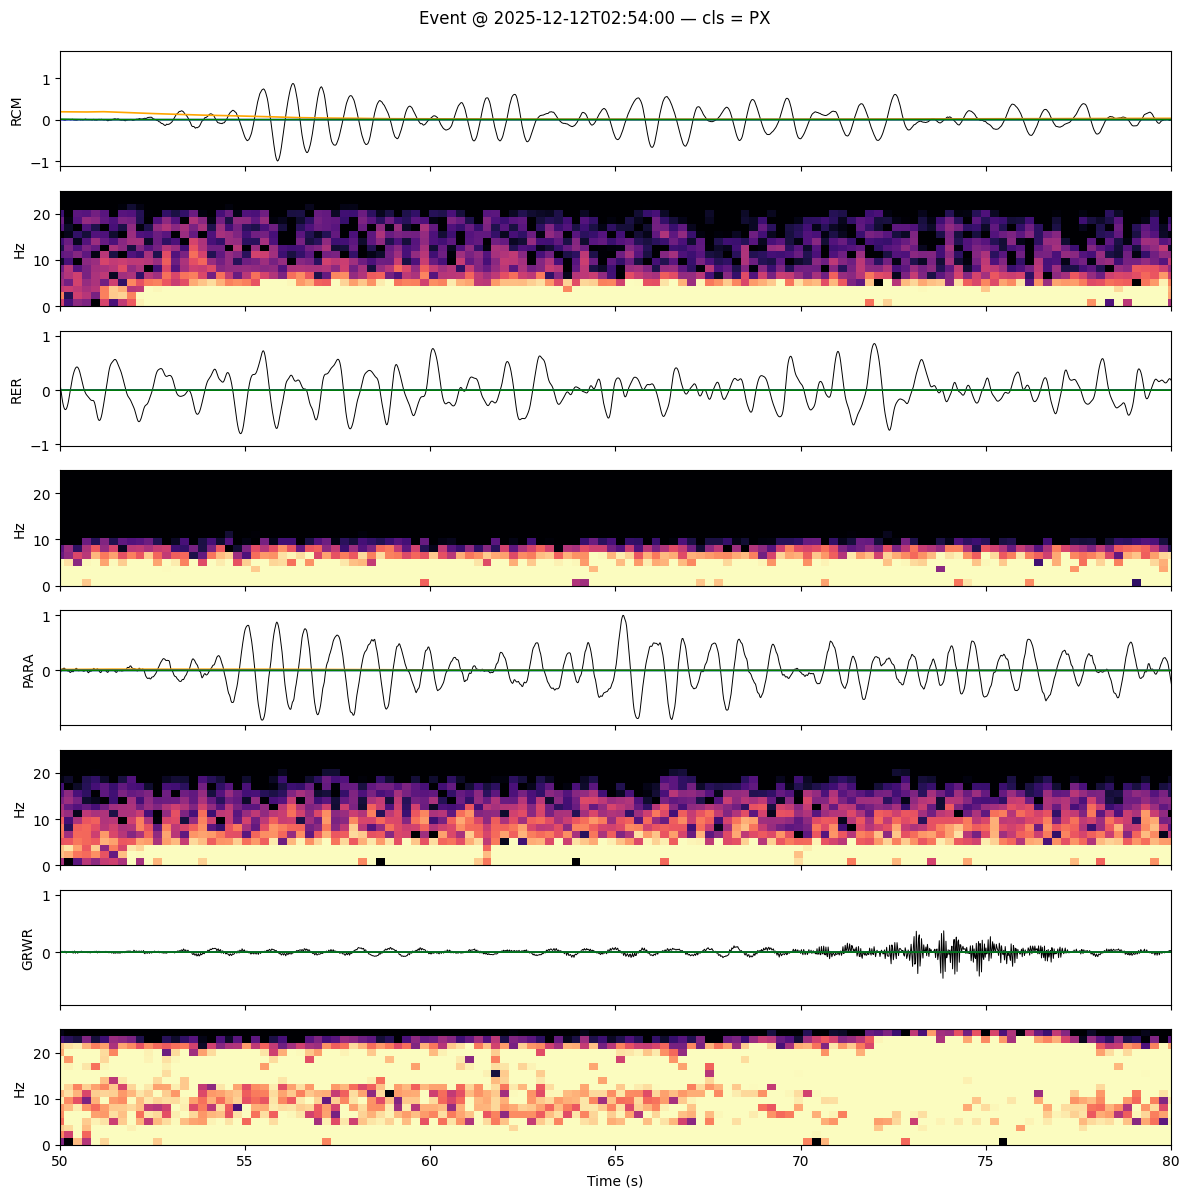

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


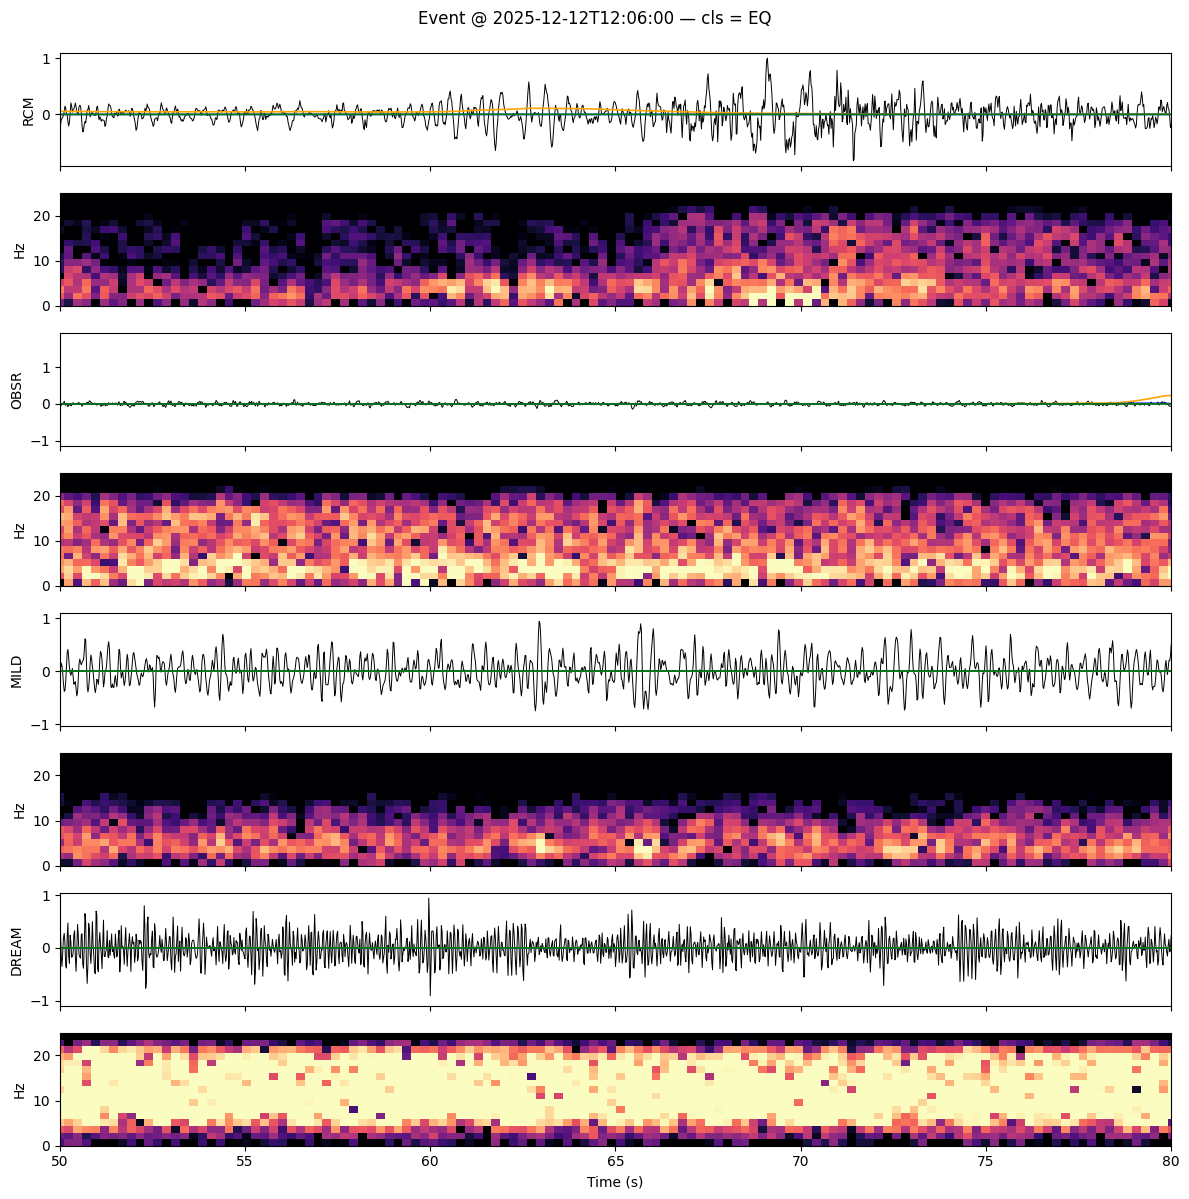

In [123]:
for i in range(len(common_events)):
    plot_event_waveforms_and_picks(common_events.iloc[i], duration= 180, model = eqt_model)

❌ LONR: No data available for request.
HTTP Status code: 204
Detailed response of server:




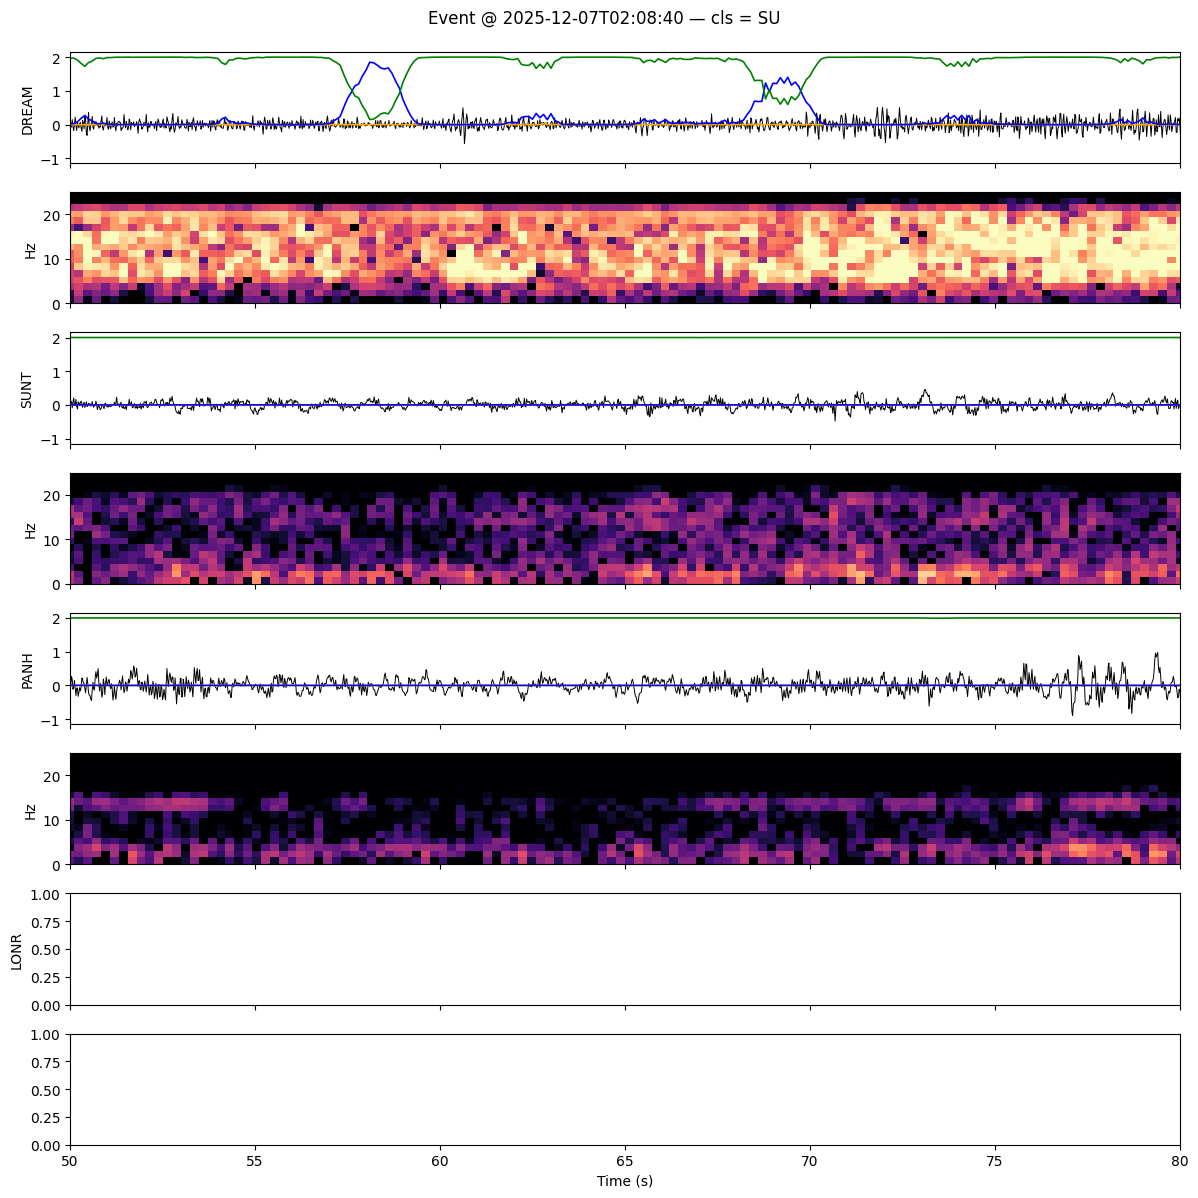

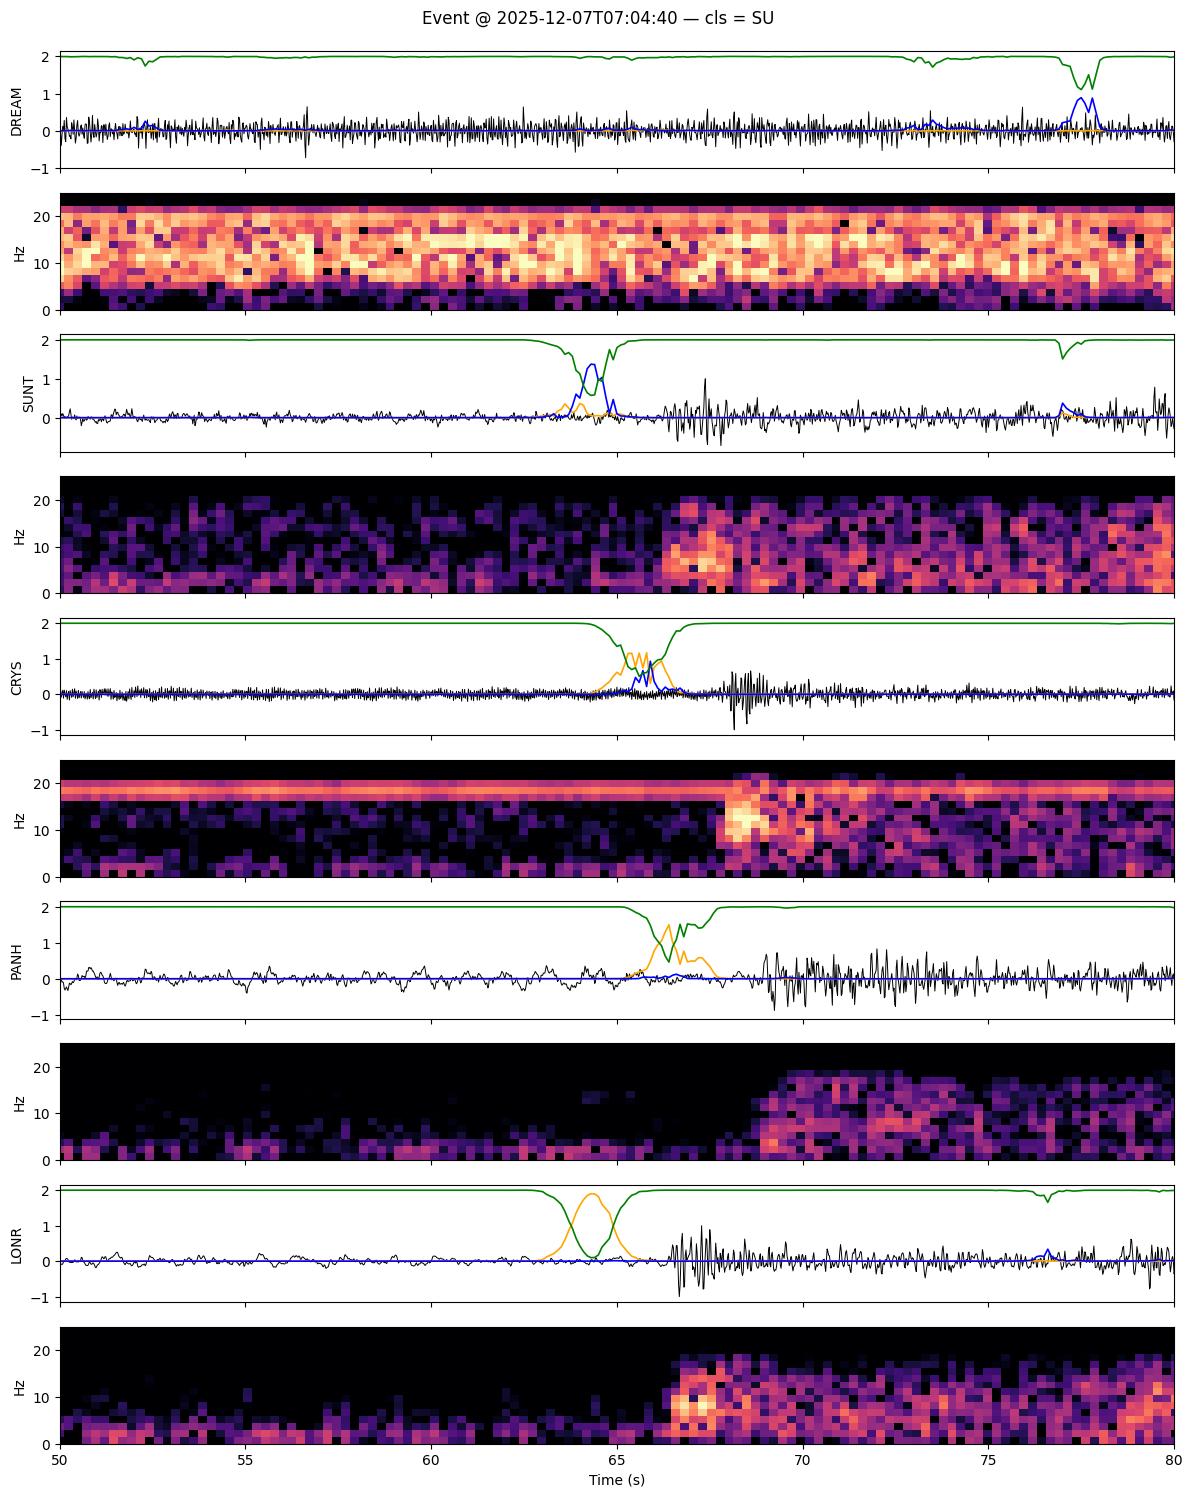

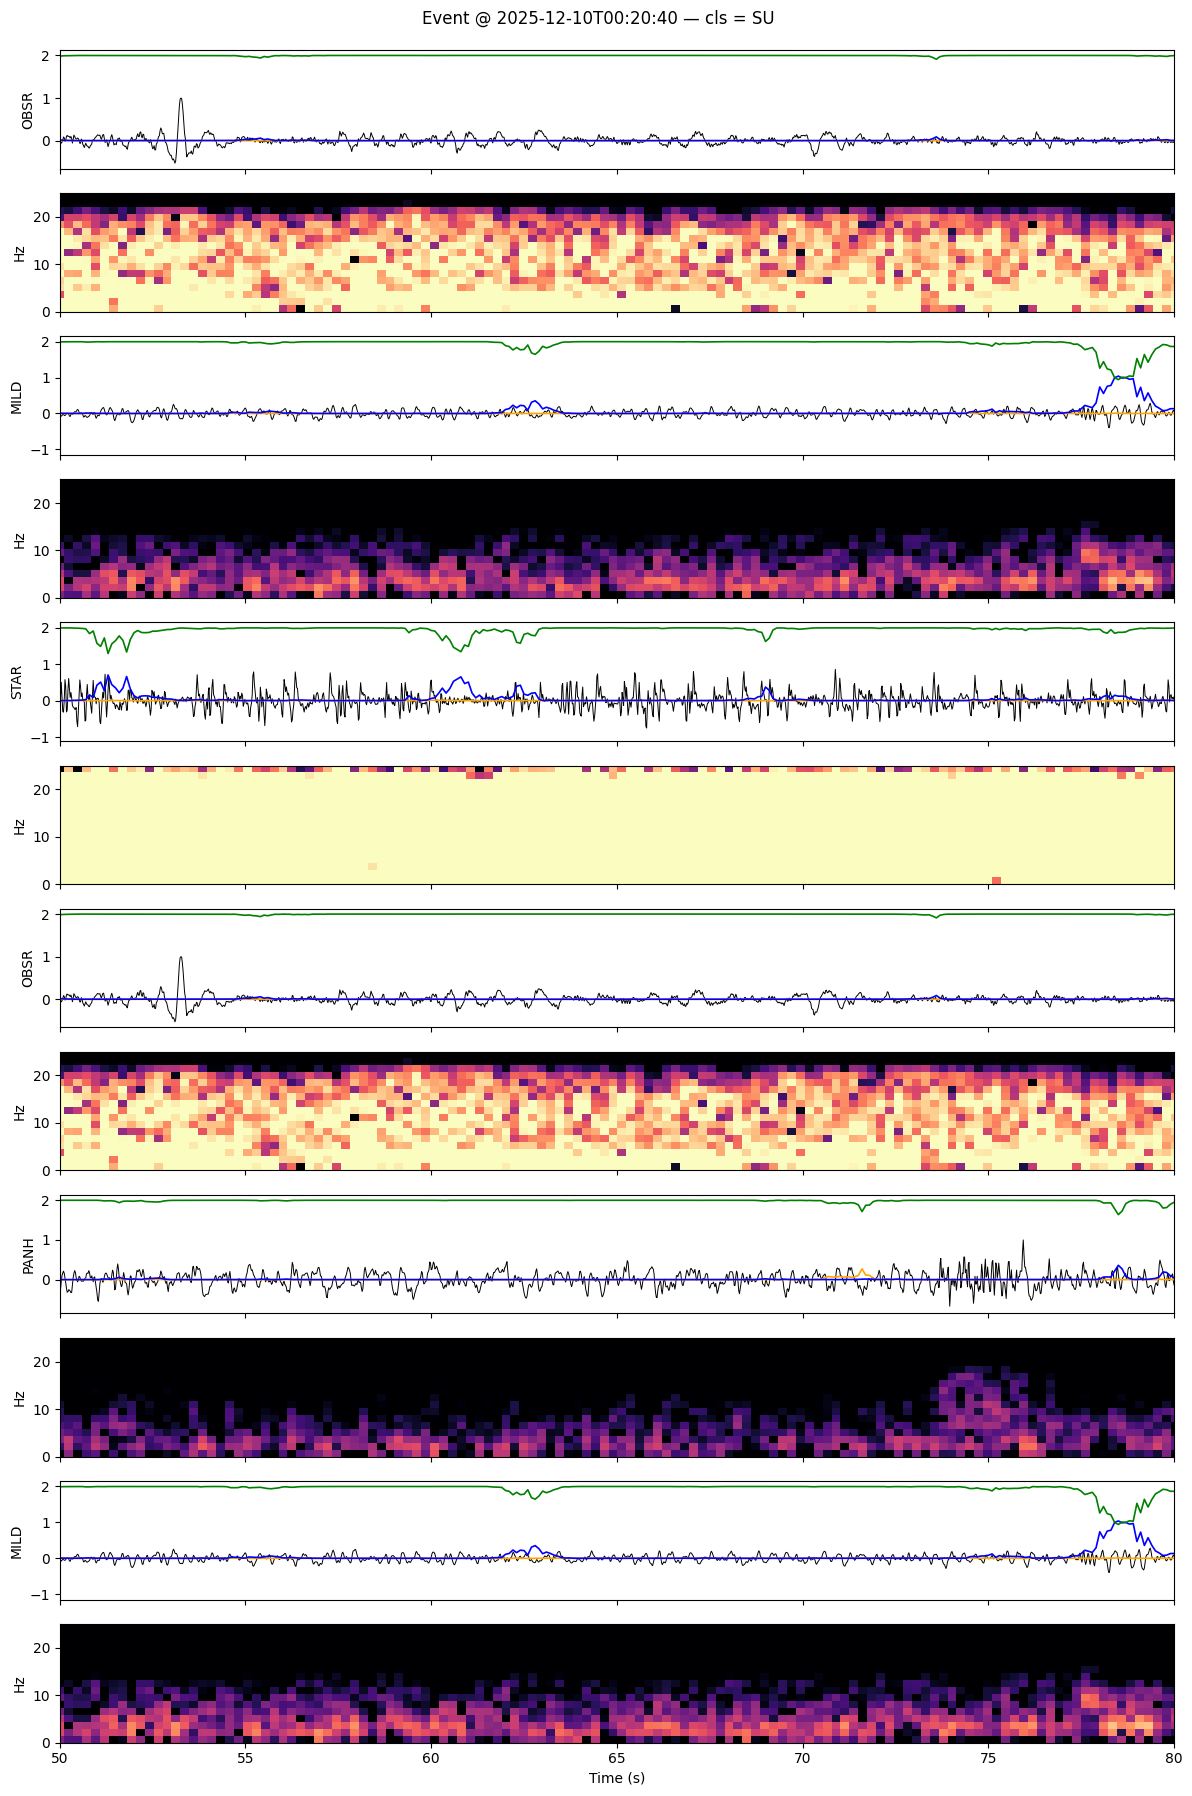

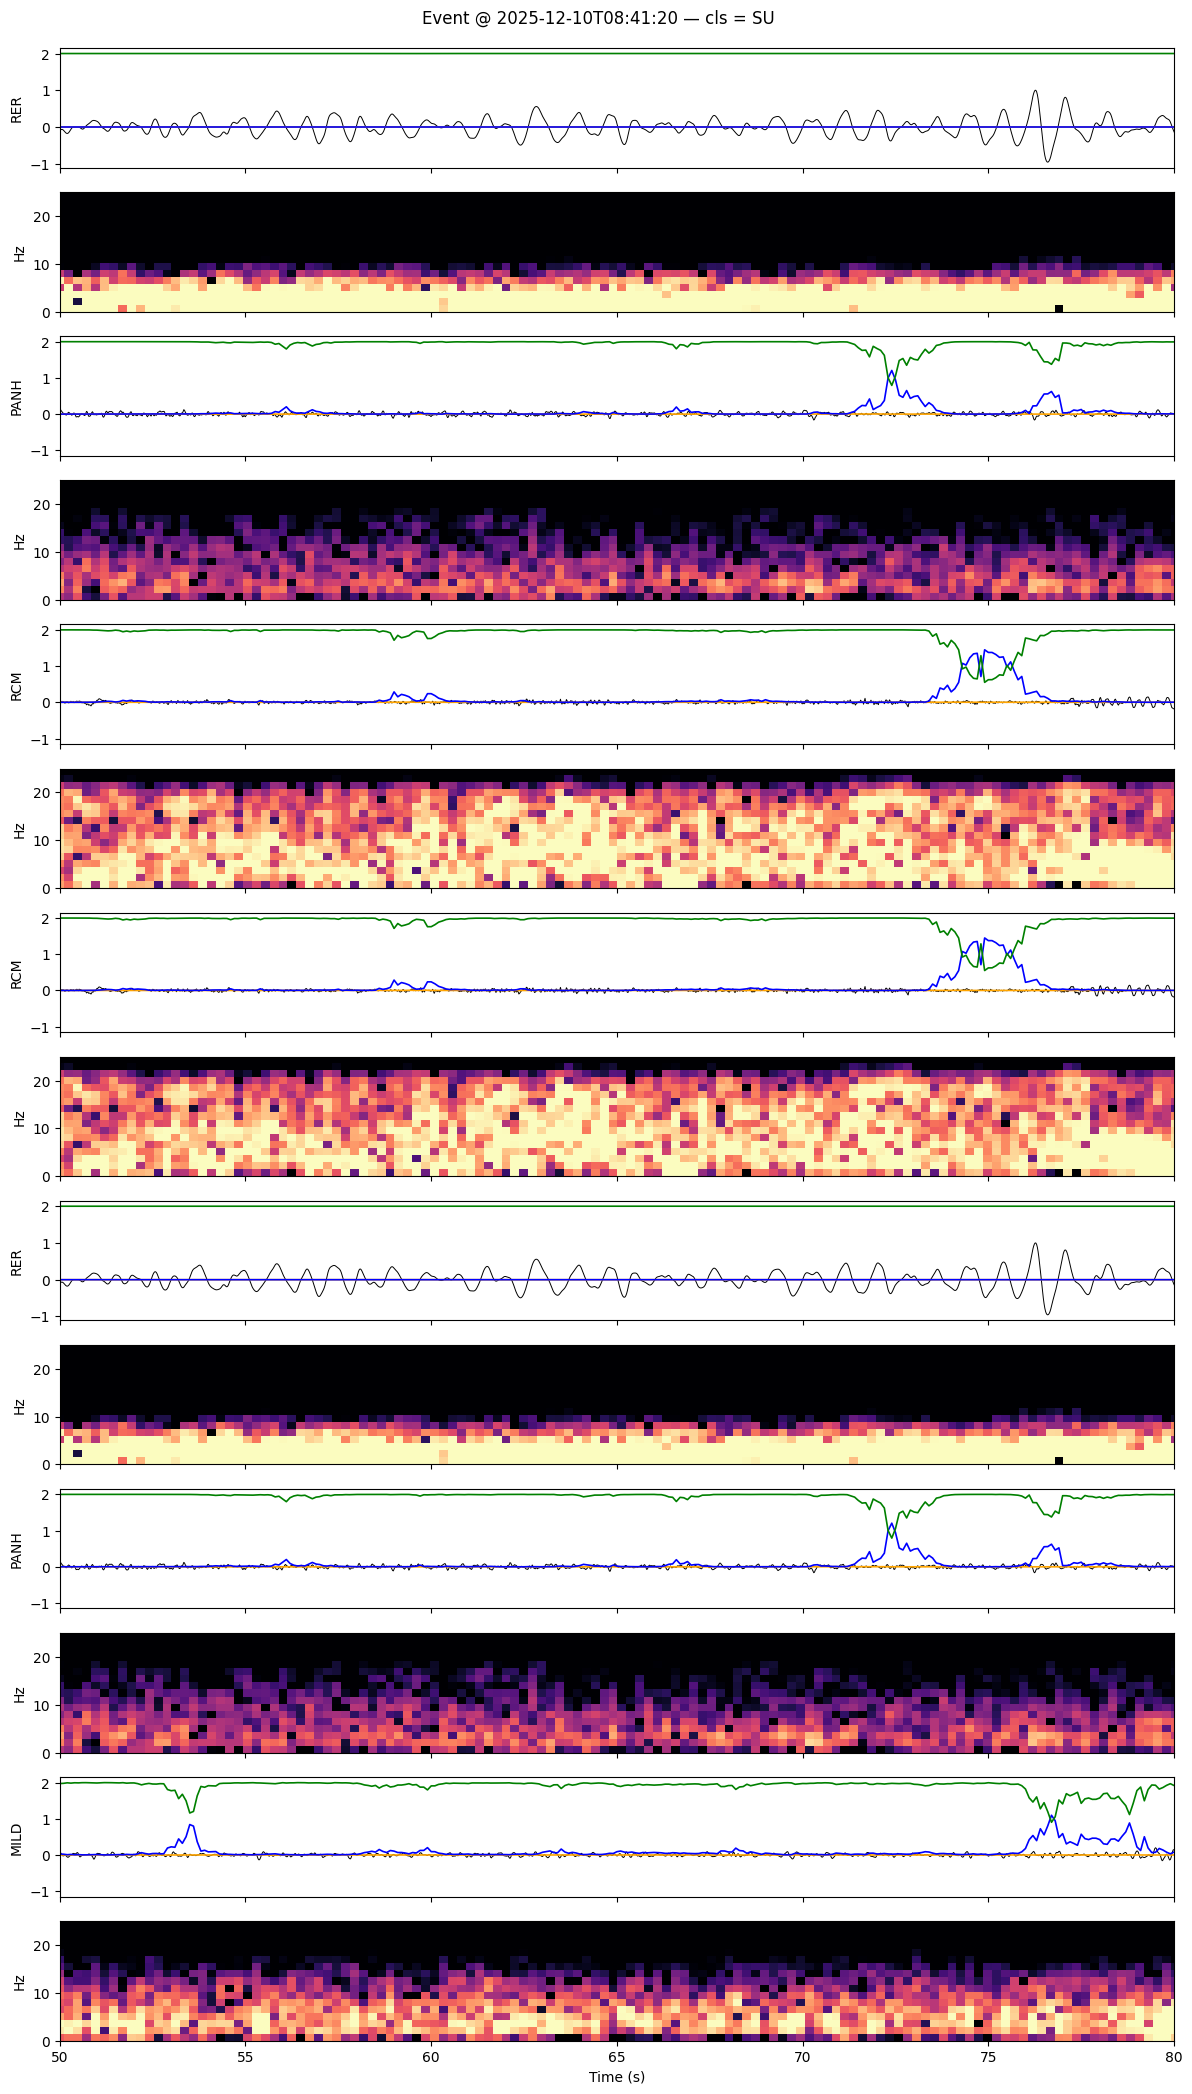

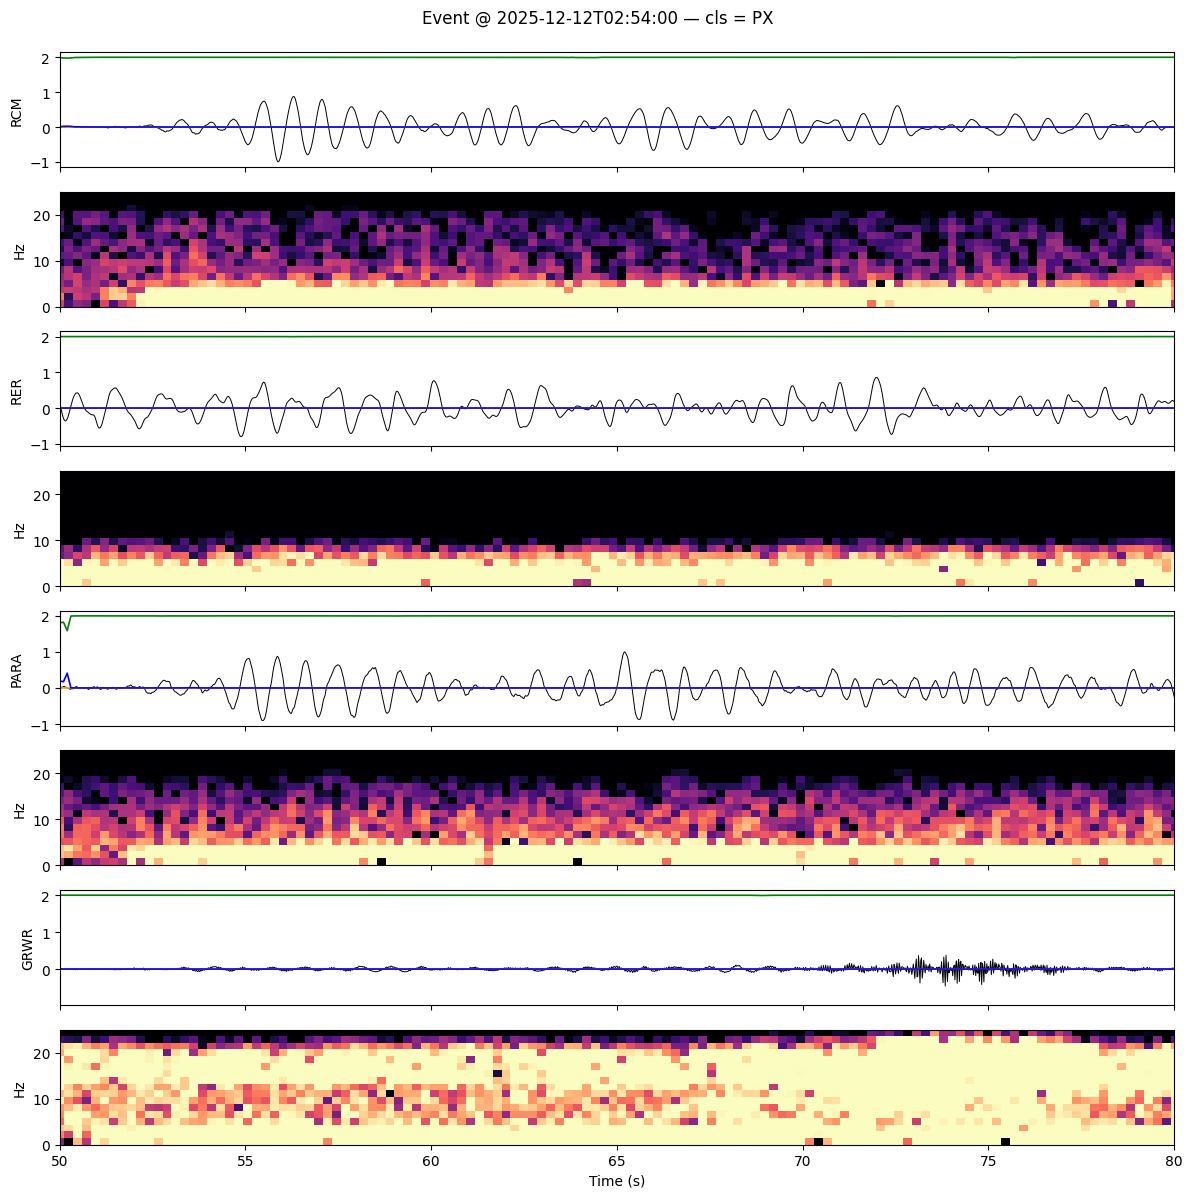

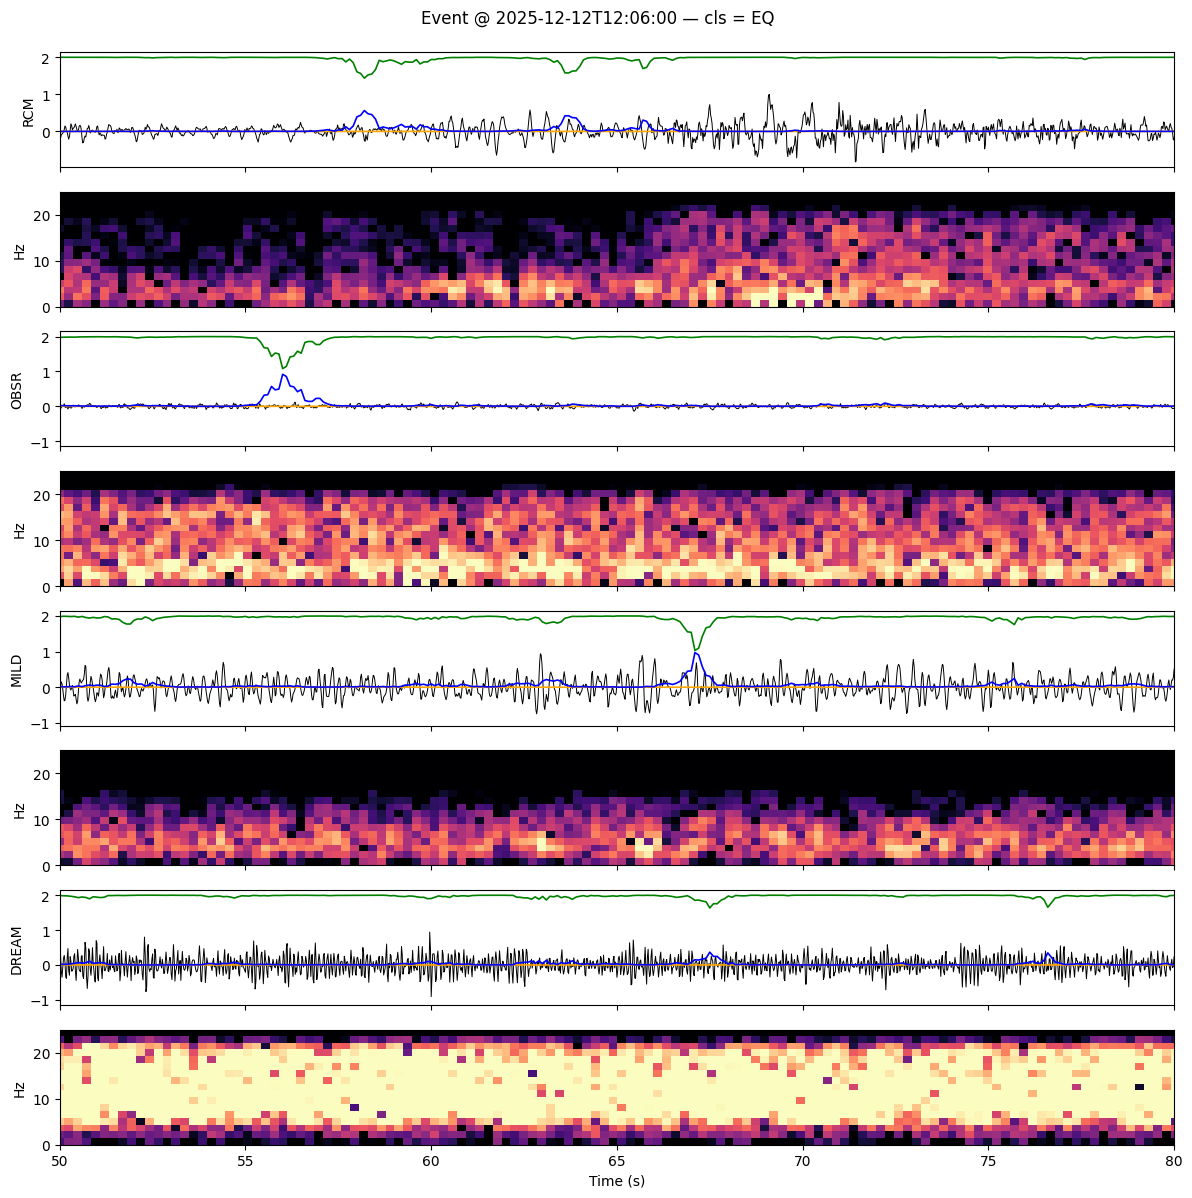

In [124]:
for i in range(len(common_events)):
    plot_event_waveforms_and_picks(common_events.iloc[i], duration= 180, model = gpd_model)


In [213]:
pn_model.cuda();
eqt_model.cuda();
gpd_model.cuda();

In [ ]:


client = Client("IRIS")
event_time  = UTCDateTime(event_row["rounded_start"])
stream = client.get_waveforms(network="CC", station="PANH", location="*", channel="*H?", 
                              starttime= event_time, 
                              endtime=t+300)


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend();